## Creating a logistic regression model in Python!

In [272]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [273]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [274]:
ride_ids = ['15692']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [275]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 1

## Drop the NA values from the dataframe:

In [276]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [277]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

## Sync the velocity info from .FIT files (this example specific to ride_id = 15692): 

In [278]:

##Open file: 
print("Reading file...")
filename = "2018-11-09-11-16-27.csv"
file = open(filename, "r")

acc_x = []
acc_y = []
acc_z = []

gyro_x = []
gyro_y = []
gyro_z = []

mag_x = []
mag_y = []
mag_z = []

distance_14_array = []
speed_14_array = []
altitude_14_array = []
das_14_time = []

distance_0_array = []
speed_0_array = []
altitude_0_array = []
velocity_0_array = []
das_0_time = []

last_sec = 0
last_ms = 0

velocity_x_array = []
velocity_y_array = []
velocity_z_array = []

#Data,10,gyroscope_data,timestamp,"4",s
#Data,11,accelerometer_data,timestamp, "4", s
#Data,12,magnetometer_data,timestamp,"4",s

##Read in lines, append values to arrays:
count = 0
for full_line in file:
    line = full_line.split(',')

    #print(line)

    #Add gyroscope data: 
    if "gyroscope_data" in line: 
        timestamp = line[4]
        gyro_x_vals = line[10].strip('\"')
        for val in gyro_x_vals.split('|'):
            gyro_x.append(val)
        gyro_y_vals = line[13].strip('\"')
        for val in gyro_y_vals.split('|'):
            gyro_y.append(val)
        gyro_z_vals = line[16].strip('\"')
        for val in gyro_z_vals.split('|'):
            gyro_z.append(val)



    #Add accelerometer data: 
    elif ("accelerometer_data" in line): 
        #print("Acc")
        timestamp = line[4]
        acc_x_vals = line[10].strip('\"')
        for val in acc_x_vals.split('|'):
            #print(val)
            acc_x.append(val)
        acc_y_vals = line[13].strip('\"')
        for val in acc_y_vals.split('|'):
            acc_y.append(val)
        acc_z_vals = line[16].strip('\"')
        for val in acc_z_vals.split('|'):
            acc_z.append(val) 

    #Add magnetometer data: 
    elif "magnetometer_data" in line: 
        timestamp = line[4]
        mag_x_vals = line[10].strip('\"')
        for val in mag_x_vals.split('|'):
            mag_x.append(val)
        mag_y_vals = line[13].strip('\"')
        for val in mag_y_vals.split('|'):
            mag_y.append(val)
        mag_z_vals = line[16].strip('\"')
        for val in mag_z_vals.split('|'):
            mag_z.append(val)

    #elif "Data" and "7" and "record" and "distance" and "m" in line: 
        #timestamp = line[3]              ##timestamp in seconds
        #distance = line[6]
        #distance_array.append(distance)  ##distance in meters



    elif ("Data" and "14" and "record" and "m/s") in line:
        #print("Here")
        timestamp = line[4].strip('\"')
        timestamp = int(timestamp)
        position_lat = line[7]
        position_long = line[10]
        distance = line[13]
        enhanced_speed = line[16].strip('\"')        ##enhanced_speed in m/s
        enhanced_alt = line[19]                      ##enhanced_altitude in m 


        if timestamp == last_sec: 
            last_ms += .1
            timestamp = timestamp + last_ms
        else: 
            last_sec = timestamp
            last_ms = 0

        das_14_time.append(timestamp)

        speed_14_array.append(enhanced_speed)
        altitude_14_array.append(enhanced_alt)
        distance_14_array.append(distance)




    elif ("gps_metadata" and "velocity" and "m/s") in line: 
        timestamp = line[4]
        position_lat = line[7]
        position_long = line[10]
        distance = line[13]
        enhanced_speed = line[16]        ##enhanced_speed in m/s
        enhanced_alt = line[19]          ##enhanced_altitude in m 

        velocity = line[28]
        velocity = velocity.strip('\"').split("|")
        if (len(velocity)==3):
            velocity_x = velocity[0]
            velocity_y = velocity[1]
            velocity_z = velocity[2]
            #print(velocity)
            velocity_x_array.append(velocity_x)
            velocity_y_array.append(velocity_y)
            velocity_z_array.append(velocity_z)

        das_0_time.append(timestamp)

        speed_0_array.append(enhanced_speed)
        altitude_0_array.append(enhanced_alt)
        distance_0_array.append(distance)


#Note: need to drop the first value (garbage) from every acc_x, y, z array. 

#file.close()

#print(das_14_time)  #2 x 6s then 10 x all other numbers until maybe end? 
print(len(speed_14_array))
print(len(das_14_time))
print(len(acc_x))
print(len(velocity_x_array))
#print("Speed data: ", speed_14_array)
#print("Time data: ", das_14_time)
zipped = zip(speed_14_array, das_14_time)
print("\n")
print("Zipped Time/Speed data: \n")
for x,y in zipped:
    print(x,y)
#print("Accelerometer Y data: ", acc_y)


    
    

Reading file...
31501
31501
363421
0


Zipped Time/Speed data: 

3.844 6
1.83 6.1
1.374 7
1.181 7.1
0.966 7.2
0.793 7.3
0.793 7.4
0.672 7.5
0.642 7.6
0.543 7.7
0.479 7.8
0.46 7.9
0.449 8
0.511 8.1
0.533 8.2
0.547 8.3
0.541 8.4
0.561 8.5
0.566 8.6
0.568 8.7
0.571 8.8
0.569 8.9
0.562 9
0.543 9.1
0.504 9.2
0.495 9.3
0.463 9.4
0.0 9.5
0.0 9.6
0.0 9.7
0.0 9.8
0.0 9.9
0.0 10
0.0 10.1
0.0 10.2
0.0 10.3
0.0 10.4
0.0 10.5
0.0 10.6
0.0 10.7
0.269 10.8
0.271 10.9
0.274 11
0.28 11.1
0.281 11.2
0.28 11.3
0.276 11.4
0.257 11.5
0.239 11.6
0.225 11.7
0.0 11.8
0.0 11.9
0.0 12
0.0 12.1
0.0 12.2
0.0 12.3
0.0 12.4
0.0 12.5
0.0 12.6
0.0 12.7
0.0 12.8
0.0 12.9
0.0 13
0.233 13.1
0.246 13.2
0.243 13.3
0.266 13.4
0.295 13.5
0.323 13.6
0.35 13.7
0.375 13.8
0.417 13.9
0.435 14
0.427 14.1
0.421 14.2
0.42 14.3
0.402 14.4
0.368 14.5
0.331 14.6
0.293 14.7
0.26 14.8
0.254 14.9
0.24 15
0.224 15.1
0.22 15.2
0.215 15.3
0.0 15.4
0.0 15.5
0.0 15.6
0.0 15.7
0.0 15.8
0.0 16
0.0 16.1
0.0 16.2
0.0 16.3
0.0 16.4
0.0 16.5
0.0 1

0.301 189.9
0.291 190
0.259 190.1
0.228 190.2
0.224 190.3
0.196 190.4
0.176 190.5
0.0 190.6
0.0 190.7
0.0 190.8
0.0 190.9
0.0 191
0.0 191.1
0.0 191.2
0.0 191.3
0.0 191.4
0.0 191.5
0.183 191.6
0.162 191.7
0.165 191.8
0.164 191.9
0.164 192
0.162 192.1
0.159 192.2
0.161 192.3
0.162 192.4
0.167 192.5
0.171 192.6
0.169 192.7
0.162 192.8
0.144 193
0.0 193.1
0.0 193.2
0.0 193.3
0.0 193.4
0.0 193.5
0.0 193.6
0.183 193.7
0.197 193.8
0.0 193.9
0.0 194
0.0 194.1
0.0 194.2
0.0 194.3
0.0 194.4
0.0 194.5
0.0 194.6
0.0 194.7
0.361 194.8
0.0 194.9
0.228 195
0.0 195.1
0.215 195.2
0.205 195.3
0.205 195.4
0.19 195.5
0.186 195.6
0.187 195.7
0.195 195.8
0.0 195.9
0.217 196
0.237 196.1
0.0 196.2
0.233 196.3
0.224 196.4
0.222 196.5
0.219 196.6
0.226 196.7
0.22 196.8
0.208 196.9
0.205 197
0.208 197.1
0.296 197.2
0.289 197.3
0.312 197.4
0.432 197.5
0.279 197.6
0.265 197.7
0.254 197.8
0.245 198
0.262 198.1
0.279 198.2
0.29 198.3
0.289 198.4
0.557 198.5
0.426 198.6
0.429 198.7
0.447 198.8
0.586 198.9
0.605 199
0

0.0 316.5
0.312 316.6
0.322 316.7
0.349 316.8
0.382 316.9
0.415 317
0.65 317.1
0.644 317.2
0.878 317.3
1.495 317.4
1.589 317.5
1.618 317.6
1.658 317.7
1.748 317.8
1.77 318
1.763 318.1
1.65 318.2
1.642 318.3
1.47 318.4
1.306 318.5
1.178 318.6
0.888 318.7
0.497 318.8
0.0 318.9
0.0 319
0.0 319.1
0.0 319.2
0.0 319.3
0.0 319.4
0.0 319.5
0.0 319.6
0.0 319.7
0.0 319.8
0.0 319.9
0.0 320.0
0.0 320
0.0 320.1
0.0 320.2
0.0 320.3
0.303 320.4
0.309 320.5
0.313 320.6
0.322 320.7
0.334 320.8
0.344 320.9
0.353 321
0.361 321.1
0.0 321.2
0.0 321.3
0.0 321.4
0.371 321.5
0.386 321.6
0.0 321.7
0.372 321.8
0.585 321.9
0.449 322
0.488 322.1
0.796 322.2
0.793 322.3
0.566 322.4
0.422 322.5
0.447 322.6
0.332 322.7
0.495 322.8
0.699 322.9
0.527 323
0.851 323.1
1.216 323.2
1.213 323.3
0.787 323.4
0.557 323.5
0.905 323.6
0.552 323.7
1.091 323.8
1.48 323.9
1.498 324
1.343 324.1
1.351 324.2
1.344 324.3
1.454 324.4
1.334 324.5
1.314 324.6
1.181 324.7
0.902 324.8
0.0 324.9
0.0 325
0.391 325.1
0.554 325.2
0.551 325.3
0

0.282 444
0.308 444.1
0.702 444.2
0.7 444.3
0.556 444.4
1.111 444.5
1.115 444.6
1.094 444.7
1.122 444.8
1.117 444.9
1.125 445
0.602 445.1
0.836 445.2
0.83 445.3
0.479 445.4
0.341 445.5
0.0 445.6
0.0 445.7
0.0 445.8
0.0 445.9
0.0 446
0.0 446.1
0.0 446.2
0.362 446.3
0.0 446.4
0.0 446.5
0.0 446.6
0.0 446.7
0.0 446.8
0.143 447
0.15 447.1
0.152 447.2
0.149 447.3
0.0 447.4
0.0 447.5
0.137 447.6
0.171 447.7
0.29 447.8
0.27 447.9
0.0 448
0.0 448.1
0.0 448.2
0.0 448.3
0.0 448.4
0.308 448.5
0.62 448.6
0.852 448.7
0.604 448.8
0.497 448.9
0.385 449
0.407 449.1
0.418 449.2
0.411 449.3
0.452 449.4
0.306 449.5
0.312 449.6
0.854 449.7
1.059 449.8
1.063 450
1.05 450.1
0.366 450.2
0.364 450.3
0.351 450.4
0.365 450.5
0.997 450.6
0.289 450.7
0.297 450.8
0.397 450.9
0.311 451
0.453 451.1
0.442 451.2
0.439 451.3
0.422 451.4
0.638 451.5
0.639 451.6
0.616 451.7
0.583 451.8
0.582 451.9
0.606 452
0.835 452.1
0.817 452.2
0.812 452.3
0.707 452.4
0.714 452.5
0.605 452.6
0.686 452.7
0.803 452.8
0.786 453
0.774 453.

1.251 576.5
1.251 576.6
1.252 576.7
1.254 576.8
1.26 577
1.268 577.1
1.278 577.2
1.278 577.3
1.293 577.4
1.31 577.5
1.328 577.6
1.346 577.7
1.363 577.8
1.375 578
1.385 578.1
1.39 578.2
1.381 578.3
1.386 578.4
1.376 578.5
1.374 578.6
1.372 578.7
1.356 578.8
1.182 578.9
1.091 579
1.058 579.1
1.028 579.2
1.026 579.3
1.008 579.4
0.999 579.5
1.001 579.6
0.989 579.7
1.088 579.8
1.124 579.9
1.396 580
1.373 580.1
1.372 580.2
1.252 580.3
1.227 580.4
1.121 580.5
1.026 580.6
0.99 580.7
0.891 580.8
1.155 581
0.986 581.1
1.072 581.2
1.064 581.3
1.528 581.4
1.083 581.5
0.971 581.6
0.796 581.7
0.659 581.8
0.571 582
0.422 582.1
0.503 582.2
0.495 582.3
1.119 582.4
1.407 582.5
1.755 582.6
2.356 582.7
2.317 582.8
2.512 583
2.662 583.1
2.642 583.2
2.641 583.3
2.496 583.4
2.391 583.5
2.483 583.6
2.384 583.7
2.268 583.8
2.023 583.9
1.639 584
1.456 584.1
1.125 584.2
1.12 584.3
0.974 584.4
0.584 584.5
0.785 584.6
0.571 584.7
0.474 584.8
0.453 585
0.444 585.1
0.304 585.2
0.299 585.3
0.387 585.4
0.419 585.5
0.5

0.242 709.7
0.236 709.8
0.255 710
0.292 710.1
0.304 710.2
0.299 710.3
0.269 710.4
0.0 710.5
0.171 710.6
0.204 710.7
0.201 710.8
0.0 710.9
0.0 711
0.0 711.1
0.0 711.2
0.0 711.3
0.0 711.4
0.0 711.5
0.0 711.6
0.0 711.7
0.0 711.8
0.0 712
0.0 712.1
0.0 712.2
0.0 712.3
0.0 712.4
0.158 712.5
0.171 712.6
0.178 712.7
0.2 712.8
0.219 712.9
0.0 713
0.0 713.1
0.0 713.2
0.0 713.3
0.0 713.4
0.0 713.5
0.0 713.6
0.227 713.7
0.235 713.8
0.0 713.9
0.0 714
0.0 714.1
0.0 714.2
0.693 714.3
0.0 714.4
0.311 714.5
0.489 714.6
0.831 714.7
0.956 714.8
0.968 715
1.105 715.1
0.99 715.2
0.989 715.3
1.118 715.4
1.091 715.5
1.068 715.6
0.888 715.7
0.735 715.8
0.763 715.9
0.753 716
0.576 716.1
0.569 716.2
0.428 716.3
0.435 716.4
0.418 716.5
0.32 716.6
0.352 716.7
0.389 716.8
0.497 717
1.002 717.1
0.484 717.2
0.476 717.3
0.606 717.4
0.829 717.5
0.719 717.6
0.894 717.7
0.715 717.8
0.918 717.9
0.943 718
1.647 718.1
1.642 718.2
0.955 718.3
0.652 718.4
0.479 718.5
0.465 718.6
0.0 718.7
0.0 718.8
0.305 719
0.314 719.1
0.30

1.293 845
1.191 845.1
1.323 845.2
1.316 845.3
1.424 845.4
1.586 845.5
1.819 845.6
1.594 845.7
1.456 845.8
1.314 846
1.148 846.1
1.181 846.2
1.176 846.3
1.144 846.4
1.008 846.5
1.156 846.6
0.926 846.7
0.0 846.8
0.0 847
0.315 847.1
0.0 847.2
0.0 847.3
0.354 847.4
0.328 847.5
0.0 847.6
0.0 847.7
0.0 847.8
0.0 848
0.0 848.1
0.0 848.2
0.0 848.3
0.224 848.4
0.25 848.5
0.343 848.6
0.329 848.7
0.338 848.8
0.336 848.9
0.337 849
0.328 849.1
0.327 849.2
0.319 849.3
0.301 849.4
0.275 849.5
0.255 849.6
0.531 849.7
0.0 849.8
0.0 850
0.415 850.1
0.411 850.2
0.0 850.3
0.0 850.4
0.282 850.5
0.287 850.6
0.304 850.7
0.335 851
0.0 851.1
1.051 851.2
1.045 851.3
0.411 851.4
0.4 851.5
0.531 851.6
0.824 851.7
0.552 851.8
0.673 852
0.477 852.1
0.824 852.2
0.821 852.3
0.0 852.4
0.0 852.5
0.0 852.6
0.0 852.7
0.285 852.8
0.419 853
0.72 853.1
0.381 853.2
0.373 853.3
0.386 853.4
0.467 853.5
0.444 853.6
0.294 853.7
0.312 853.8
0.318 854
0.467 854.1
0.454 854.2
0.448 854.3
0.421 854.4
0.413 854.5
0.532 854.6
0.432 85

1.12 984.6
0.33 984.7
0.334 984.8
0.549 985
0.777 985.1
0.0 985.2
0.0 985.3
0.272 985.4
0.462 985.5
1.246 985.6
0.77 985.7
0.784 985.8
1.035 986
1.299 986.1
0.946 986.2
0.942 986.3
0.824 986.4
0.99 986.5
1.307 986.6
0.701 986.7
0.918 986.8
1.178 987
1.352 987.1
1.124 987.2
1.12 987.3
1.272 987.4
1.278 987.5
1.482 987.6
1.176 987.7
1.264 987.8
1.285 988
1.378 988.1
1.158 988.2
1.157 988.3
1.145 988.4
1.111 988.5
1.078 988.6
0.925 988.7
0.669 988.8
0.921 989
1.087 989.1
0.473 989.2
0.467 989.3
0.681 989.4
1.271 989.5
0.664 989.6
0.919 989.7
1.273 989.8
1.599 990
1.321 990.1
1.329 990.2
1.325 990.3
1.412 990.4
1.252 990.5
1.248 990.6
1.167 990.7
1.131 990.8
1.139 991
1.289 991.1
1.288 991.2
1.141 991.3
1.15 991.4
1.121 991.5
0.783 991.6
0.39 991.7
0.304 992
0.331 992.1
0.0 992.2
0.0 992.3
0.0 992.4
0.0 992.5
0.163 992.6
0.203 992.7
0.0 992.8
0.189 992.9
0.201 993
0.698 993.1
0.69 993.2
0.0 993.3
0.409 993.4
0.575 993.5
1.074 993.6
0.698 993.7
0.663 994
1.243 994.1
0.766 994.2
0.765 994.3


0.0 1124.4
0.0 1124.5
0.0 1124.6
0.0 1124.7
0.164 1124.8
0.181 1125
0.182 1125.1
0.188 1125.2
0.187 1125.3
0.202 1125.4
0.318 1125.5
0.317 1125.6
0.332 1125.7
0.367 1125.8
0.461 1126
0.309 1126.1
0.299 1126.2
0.299 1126.3
0.0 1126.4
0.192 1126.5
0.193 1126.6
0.205 1126.7
0.228 1126.8
0.32 1127
0.336 1127.1
0.352 1127.2
0.345 1127.3
0.317 1127.4
0.29 1127.5
0.166 1127.6
0.188 1127.7
0.19 1127.8
0.196 1128
0.359 1128.1
0.0 1128.2
0.0 1128.3
0.0 1128.4
0.199 1128.5
0.195 1128.6
0.166 1128.7
0.0 1128.8
0.0 1129
0.0 1129.1
0.0 1129.2
0.0 1129.3
0.0 1129.4
0.0 1129.5
0.0 1129.6
0.0 1129.7
0.0 1129.8
0.0 1130
0.0 1130.1
0.0 1130.2
0.0 1130.3
0.0 1130.4
0.0 1130.5
0.217 1130.6
0.0 1130.7
0.0 1130.8
0.0 1131
0.266 1131.1
0.0 1131.2
0.0 1131.3
0.244 1131.4
0.252 1131.5
0.262 1131.6
0.276 1131.7
0.274 1131.8
0.271 1132
0.0 1132.1
0.0 1132.2
0.0 1132.3
0.0 1132.4
0.0 1132.5
0.0 1132.6
0.0 1132.7
0.0 1132.8
0.0 1133
0.0 1133.1
0.0 1133.2
0.0 1133.3
0.0 1133.4
0.0 1133.5
0.0 1133.6
0.0 1133.7
0.319 

0.0 1265.2
0.0 1265.3
0.268 1265.4
0.488 1265.5
0.757 1265.6
0.49 1265.7
0.511 1265.8
0.481 1266
0.293 1266.1
0.273 1266.2
0.271 1266.3
0.192 1266.4
0.173 1266.5
0.0 1266.6
0.0 1266.7
0.0 1266.8
0.0 1267
0.0 1267.1
0.0 1267.2
0.0 1267.3
0.0 1267.4
0.26 1267.5
0.0 1267.6
0.0 1267.7
0.162 1267.8
0.159 1268
0.17 1268.1
0.166 1268.2
0.159 1268.3
0.164 1268.4
0.18 1268.5
0.0 1268.6
0.0 1268.7
0.0 1268.8
0.0 1269
0.0 1269.1
0.0 1269.2
0.0 1269.3
0.0 1269.4
0.0 1269.5
0.0 1269.6
0.0 1269.7
0.0 1269.8
0.0 1270
0.0 1270.1
0.0 1270.2
0.0 1270.3
0.0 1270.4
0.0 1270.5
0.391 1270.6
0.376 1270.7
0.269 1270.8
0.266 1271
0.298 1271.1
0.0 1271.2
0.0 1271.3
0.23 1271.4
0.244 1271.5
0.234 1271.6
0.0 1271.7
0.0 1271.8
0.0 1272
0.175 1272.1
0.0 1272.2
0.0 1272.3
0.213 1272.4
0.234 1272.5
0.254 1272.6
0.259 1272.7
0.253 1272.8
0.24 1273
0.152 1273.1
0.158 1273.2
0.149 1273.3
0.146 1273.4
0.0 1273.5
0.339 1273.6
0.316 1273.7
0.465 1273.8
0.634 1274
0.656 1274.1
0.505 1274.2
0.504 1274.3
0.491 1274.4
0.323 12

0.206 1414.1
0.205 1414.2
0.216 1414.3
0.219 1414.4
0.232 1414.5
0.418 1414.6
0.41 1414.7
0.38 1414.8
0.387 1415
0.299 1415.1
0.299 1415.2
0.287 1415.3
0.261 1415.4
0.0 1415.5
0.203 1415.6
0.0 1415.7
0.316 1416
0.342 1416.1
0.604 1416.2
0.597 1416.3
0.386 1416.4
0.357 1416.5
0.248 1416.6
0.21 1416.7
0.192 1416.8
0.17 1417
0.166 1417.1
0.176 1417.2
0.168 1417.3
0.17 1417.4
0.171 1417.5
0.169 1417.6
0.0 1417.7
0.0 1417.8
0.0 1417.9
0.0 1418
0.0 1418.1
0.0 1418.2
0.0 1418.3
0.0 1418.4
0.0 1418.5
0.0 1418.6
0.0 1418.7
0.0 1419
0.0 1419.1
0.175 1419.2
0.168 1419.3
0.184 1419.4
0.186 1419.5
0.197 1419.6
0.204 1419.7
0.212 1419.8
0.204 1420
0.194 1420.1
0.18 1420.2
0.177 1420.3
0.362 1420.4
0.0 1420.5
0.0 1420.6
0.0 1420.7
0.482 1420.8
0.0 1421
0.0 1421.1
0.0 1421.2
0.42 1421.3
0.0 1421.4
0.312 1421.5
0.338 1421.6
0.346 1421.7
0.0 1421.8
0.0 1422
0.0 1422.1
0.0 1422.2
0.0 1422.3
0.0 1422.4
0.0 1422.5
0.0 1422.6
0.0 1422.7
0.0 1423
0.0 1423.1
0.0 1423.2
0.0 1423.3
0.0 1423.4
0.0 1423.5
0.0 142

0.379 1547.4
0.397 1547.5
0.409 1547.6
0.414 1547.7
0.416 1548
0.0 1548.1
0.0 1548.2
0.0 1548.3
0.0 1548.4
0.0 1548.5
0.0 1548.6
0.313 1548.7
0.351 1548.8
0.623 1549
0.0 1549.1
0.311 1549.2
0.308 1549.3
0.42 1549.4
0.444 1549.5
0.468 1549.6
0.565 1549.7
0.0 1550
0.362 1550.1
0.391 1550.2
0.383 1550.3
0.511 1550.4
0.542 1550.5
0.0 1550.6
1.319 1550.7
0.7 1550.8
0.0 1551
0.699 1551.1
0.0 1551.2
0.0 1551.3
0.279 1551.4
0.403 1551.5
0.0 1551.6
0.0 1551.7
0.0 1551.8
0.374 1552
0.29 1552.1
0.291 1552.2
0.289 1552.3
0.897 1552.4
0.0 1552.5
0.383 1552.6
1.107 1552.7
0.899 1553
0.567 1553.1
1.404 1553.2
1.4 1553.3
0.947 1553.4
0.767 1553.5
1.59 1553.6
0.915 1553.7
0.627 1553.8
0.915 1554
1.328 1554.1
0.718 1554.2
0.709 1554.3
0.818 1554.4
1.438 1554.5
1.0 1554.6
0.748 1554.7
1.0 1554.8
1.3 1555
1.186 1555.1
1.166 1555.2
1.157 1555.3
1.143 1555.4
1.051 1555.5
1.033 1555.6
0.994 1555.7
0.628 1555.8
1.014 1556
0.619 1556.1
0.585 1556.2
0.579 1556.3
0.954 1556.4
0.325 1556.5
0.501 1556.6
1.058 1556

0.673 1692.5
0.78 1692.6
0.772 1692.7
0.744 1692.8
0.661 1693
0.572 1693.1
0.569 1693.2
0.565 1693.3
0.594 1693.4
0.617 1693.5
0.476 1693.6
0.309 1693.7
0.311 1694
0.0 1694.1
0.0 1694.2
0.0 1694.3
0.0 1694.4
0.358 1694.5
0.348 1694.6
0.0 1694.7
0.0 1695
0.0 1695.1
0.0 1695.2
0.0 1695.3
0.272 1695.4
0.305 1695.5
0.436 1695.6
1.343 1695.7
1.487 1695.8
0.994 1696
0.53 1696.1
0.523 1696.2
1.414 1696.3
1.437 1696.4
1.787 1696.5
1.52 1696.6
1.288 1696.7
1.158 1697
0.912 1697.1
0.945 1697.2
0.942 1697.3
0.77 1697.4
0.902 1697.5
0.868 1697.6
0.885 1697.7
0.904 1697.8
1.022 1698
1.041 1698.1
1.036 1698.2
1.237 1698.3
1.213 1698.4
1.106 1698.5
1.105 1698.6
1.321 1698.7
1.347 1699
1.332 1699.1
1.301 1699.2
1.297 1699.3
1.273 1699.4
1.613 1699.5
1.358 1699.6
1.39 1699.7
1.385 1699.8
1.354 1700
1.387 1700.1
1.381 1700.2
1.66 1700.3
1.271 1700.4
1.311 1700.5
1.458 1700.6
1.468 1700.7
1.661 1701
1.655 1701.1
1.572 1701.2
1.568 1701.3
1.535 1701.4
1.574 1701.5
1.585 1701.6
1.574 1701.7
1.829 1701.8
1.

0.644 1839.2
0.62 1839.3
0.499 1839.4
0.49 1839.5
0.391 1839.6
0.385 1839.7
0.382 1840
0.193 1840.1
0.181 1840.2
0.177 1840.3
0.16 1840.4
0.0 1840.5
0.0 1840.6
0.0 1840.7
0.0 1841
0.0 1841.1
0.0 1841.2
0.0 1841.3
0.0 1841.4
0.0 1841.5
0.163 1841.6
0.172 1841.7
0.174 1841.8
0.171 1842
0.0 1842.1
0.0 1842.2
0.0 1842.3
0.0 1842.4
0.0 1842.5
0.257 1842.6
0.0 1842.7
0.0 1843
0.272 1843.1
0.0 1843.2
0.0 1843.3
0.0 1843.4
0.34 1843.5
0.0 1843.6
0.0 1843.7
0.382 1843.8
0.0 1844
0.26 1844.1
0.252 1844.2
0.0 1844.3
0.0 1844.4
0.373 1844.5
0.0 1844.6
0.0 1844.7
0.386 1845
0.0 1845.1
0.0 1845.2
0.0 1845.3
0.418 1845.4
0.0 1845.5
0.184 1845.6
0.357 1845.7
0.0 1845.8
0.0 1845.9
0.304 1846.0
0.299 1846
0.0 1846.1
0.0 1846.2
0.179 1846.3
0.313 1846.4
0.0 1846.5
0.0 1847
0.195 1847.1
0.0 1847.2
0.0 1847.3
0.0 1847.4
0.284 1847.5
0.0 1847.6
0.213 1847.7
0.425 1847.8
0.39 1848
0.499 1848.1
0.495 1848.2
0.635 1848.3
0.631 1848.4
0.617 1848.5
0.505 1848.6
0.539 1848.7
0.517 1849
0.288 1849.1
0.477 1849.2
0

0.408 1986.4
0.279 1986.5
0.391 1986.6
0.511 1986.7
0.955 1987
0.467 1987.1
0.825 1987.2
0.821 1987.3
1.612 1987.4
0.953 1987.5
1.137 1987.6
0.883 1987.7
0.693 1988
0.836 1988.1
0.958 1988.2
0.952 1988.3
0.744 1988.4
0.9 1988.5
1.439 1988.6
1.576 1988.7
1.77 1988.8
1.52 1989
1.238 1989.1
1.128 1989.2
1.12 1989.3
0.844 1989.4
0.496 1989.5
0.654 1989.6
0.223 1989.7
0.679 1989.8
0.574 1990
0.338 1990.1
0.336 1990.2
0.372 1990.3
0.381 1990.4
0.42 1990.5
0.259 1990.6
0.253 1990.7
0.26 1991
0.402 1991.1
0.485 1991.2
0.476 1991.3
0.482 1991.4
0.391 1991.5
0.27 1991.6
0.537 1991.7
0.0 1991.8
0.243 1992
0.324 1992.1
0.317 1992.2
0.319 1992.3
0.333 1992.4
0.456 1992.5
0.321 1992.6
0.315 1992.7
0.551 1993
0.461 1993.1
0.326 1993.2
0.317 1993.3
0.333 1993.4
0.435 1993.5
0.466 1993.6
0.442 1993.7
0.34 1993.8
0.459 1994
0.477 1994.1
0.476 1994.2
0.6 1994.3
0.738 1994.4
1.717 1994.5
0.834 1994.6
1.409 1994.7
3.056 1995
2.633 1995.1
3.27 1995.2
3.266 1995.3
4.049 1995.4
4.086 1995.5
4.121 1995.6
4.154

0.636 2135.4
0.622 2135.5
0.509 2135.6
0.4 2135.7
0.418 2136
0.582 2136.1
0.758 2136.2
0.756 2136.3
0.742 2136.4
0.634 2136.5
0.465 2136.6
0.239 2136.7
0.246 2137
0.0 2137.1
0.0 2137.2
0.0 2137.3
0.0 2137.4
0.0 2137.5
0.267 2137.6
0.0 2137.7
0.0 2137.8
0.0 2138
0.138 2138.1
0.143 2138.2
0.14 2138.3
0.157 2138.4
0.243 2138.5
0.0 2138.6
0.0 2138.7
0.0 2138.8
0.134 2139
0.166 2139.1
0.159 2139.2
0.0 2139.3
0.196 2139.4
0.225 2139.5
0.24 2139.6
0.247 2139.7
0.252 2140
0.242 2140.1
0.233 2140.2
0.235 2140.3
0.236 2140.4
0.227 2140.5
0.222 2140.6
0.232 2140.7
0.23 2141
0.212 2141.1
0.195 2141.2
0.187 2141.3
0.216 2141.4
0.0 2141.5
0.0 2141.6
0.173 2141.7
0.333 2141.8
0.31 2142
0.406 2142.1
0.401 2142.2
0.313 2142.3
0.347 2142.4
0.311 2142.5
0.228 2142.6
0.207 2142.7
0.0 2143
0.135 2143.1
0.131 2143.2
0.271 2143.3
0.19 2143.4
0.209 2143.5
0.215 2143.6
0.0 2143.7
0.155 2144
0.148 2144.1
0.135 2144.2
0.131 2144.3
0.133 2144.4
0.225 2144.5
0.209 2144.6
0.189 2144.7
0.211 2144.8
0.186 2145
0.0 21

0.357 2285.5
0.24 2285.6
0.259 2285.7
0.616 2285.8
0.0 2286
0.328 2286.1
0.327 2286.2
0.289 2286.3
0.0 2286.4
0.164 2286.5
0.145 2286.6
0.0 2286.7
0.285 2287
0.0 2287.1
0.0 2287.2
0.0 2287.3
0.0 2287.4
0.0 2287.5
0.0 2287.6
0.0 2287.7
0.0 2288
0.0 2288.1
0.0 2288.2
0.0 2288.3
0.0 2288.4
0.177 2288.5
0.165 2288.6
0.167 2288.7
0.174 2288.8
0.0 2289
0.138 2289.1
0.131 2289.2
0.133 2289.3
0.0 2289.4
0.135 2289.5
0.0 2289.6
0.0 2289.7
0.303 2290
0.0 2290.1
0.179 2290.2
0.177 2290.3
0.199 2290.4
0.17 2290.5
0.323 2290.6
0.0 2290.7
0.0 2291
0.26 2291.1
0.0 2291.2
0.0 2291.3
0.167 2291.4
0.0 2291.5
0.0 2291.6
0.19 2291.7
0.177 2292
0.15 2292.1
0.134 2292.2
0.131 2292.3
0.141 2292.4
0.369 2292.5
0.273 2292.6
0.17 2292.7
0.166 2292.8
0.0 2293
0.147 2293.1
0.14 2293.2
0.0 2293.3
0.15 2293.4
0.273 2293.5
0.184 2293.6
0.154 2293.7
0.185 2294
0.178 2294.1
0.158 2294.2
0.149 2294.3
0.0 2294.4
0.0 2294.5
0.205 2294.6
0.0 2294.7
0.0 2295
0.432 2295.1
0.0 2295.2
0.0 2295.3
0.0 2295.4
0.0 2295.5
0.111 22

0.0 2444.5
0.0 2444.6
0.0 2444.7
0.0 2445
0.0 2445.1
0.0 2445.2
0.151 2445.3
0.0 2445.4
0.0 2445.5
0.143 2445.6
0.0 2446
0.12 2446.1
0.121 2446.2
0.121 2446.3
0.122 2446.4
0.124 2446.5
0.137 2446.6
0.144 2446.7
0.0 2447
0.154 2447.1
0.0 2447.2
0.0 2447.3
0.162 2447.4
0.165 2447.5
0.151 2447.6
0.244 2447.7
0.241 2448
0.512 2448.1
0.505 2448.2
0.504 2448.3
0.394 2448.4
0.362 2448.5
0.344 2448.6
0.636 2448.7
0.261 2448.8
0.231 2449
0.206 2449.1
0.205 2449.2
0.0 2449.3
0.0 2449.4
0.175 2449.5
0.529 2449.6
0.0 2450
0.384 2450.1
0.0 2450.2
0.0 2450.3
0.304 2450.4
0.198 2450.5
0.196 2450.6
0.448 2450.7
0.285 2451
0.0 2451.1
0.0 2451.2
0.0 2451.3
0.146 2451.4
0.147 2451.5
0.158 2451.6
0.291 2451.7
0.0 2452
0.0 2452.1
0.0 2452.2
0.0 2452.3
0.0 2452.4
0.0 2452.5
0.0 2452.6
0.0 2452.7
0.0 2453
0.0 2453.1
0.0 2453.2
0.0 2453.3
0.0 2453.4
0.331 2453.5
0.0 2453.6
0.203 2453.7
0.422 2453.8
0.0 2454
0.262 2454.1
0.261 2454.2
0.259 2454.3
0.0 2454.4
0.215 2454.5
0.0 2454.6
0.0 2454.7
0.0 2455
0.0 2455.

0.373 2592.3
0.268 2592.4
0.166 2592.5
0.383 2592.6
0.223 2592.7
0.197 2593
0.485 2593.1
0.0 2593.2
0.0 2593.3
0.213 2593.4
0.221 2593.5
0.21 2593.6
0.47 2593.7
0.275 2594
0.283 2594.1
0.0 2594.2
0.0 2594.3
0.0 2594.4
0.0 2594.5
0.0 2594.6
0.448 2594.7
0.482 2595
1.386 2595.1
1.074 2595.2
1.073 2595.3
1.177 2595.4
1.287 2595.5
1.293 2595.6
0.512 2595.7
0.522 2596
0.326 2596.1
0.0 2596.2
0.0 2596.3
0.0 2596.4
0.0 2596.5
0.0 2596.6
0.0 2596.7
0.0 2597
0.211 2597.1
0.181 2597.2
0.177 2597.3
0.182 2597.4
0.19 2597.5
0.21 2597.6
0.214 2597.7
0.203 2598
0.224 2598.1
0.0 2598.2
0.0 2598.3
0.0 2598.4
0.0 2598.5
0.0 2598.6
0.0 2598.7
0.233 2598.8
0.0 2599
0.446 2599.1
0.439 2599.2
0.312 2599.3
0.302 2599.4
0.613 2599.5
0.404 2599.6
0.543 2599.7
0.755 2600
0.0 2600.1
0.0 2600.2
0.453 2600.3
0.0 2600.4
0.728 2600.5
0.256 2600.6
0.246 2600.7
0.423 2601
0.439 2601.1
0.439 2601.2
0.754 2601.3
0.624 2601.4
0.585 2601.5
0.624 2601.6
0.645 2601.7
0.794 2602
0.691 2602.1
0.589 2602.2
0.588 2602.3
0.768 

1.414 2747.5
1.291 2747.6
1.327 2747.7
0.942 2748
0.314 2748.1
0.219 2748.2
0.215 2748.3
0.179 2748.4
0.0 2748.5
0.0 2748.6
0.0 2748.7
0.0 2749
0.458 2749.1
0.269 2749.2
0.261 2749.3
0.562 2749.4
0.0 2749.5
0.236 2749.6
0.733 2749.7
0.0 2749.8
0.733 2750
0.248 2750.1
0.243 2750.2
0.561 2750.3
0.595 2750.4
0.83 2750.5
1.344 2750.6
0.716 2751
1.021 2751.1
0.605 2751.2
0.597 2751.3
1.199 2751.4
0.53 2751.5
1.09 2751.6
1.44 2751.7
1.356 2752
0.86 2752.1
0.829 2752.2
0.821 2752.3
1.048 2752.4
1.145 2752.5
1.048 2752.6
0.84 2752.7
0.867 2753
0.739 2753.1
1.046 2753.2
1.045 2753.3
1.362 2753.4
1.246 2753.5
1.423 2753.6
1.593 2753.7
1.473 2754
0.923 2754.1
1.144 2754.2
1.138 2754.3
1.428 2754.4
0.452 2754.5
0.768 2754.6
0.0 2754.7
0.0 2755
0.0 2755.1
0.0 2755.2
0.0 2755.3
0.0 2755.4
0.0 2755.5
0.0 2755.6
0.196 2755.7
0.179 2755.8
0.21 2756
0.222 2756.1
0.215 2756.2
0.191 2756.3
0.189 2756.4
0.185 2756.5
0.192 2756.6
0.46 2757
0.732 2757.1
0.633 2757.2
0.625 2757.3
0.606 2757.4
1.035 2757.5
1.6

0.424 2925.2
0.42 2925.3
0.267 2925.4
0.366 2925.5
0.358 2925.6
0.364 2925.7
0.357 2925.8
0.554 2926
0.367 2926.1
0.364 2926.2
0.484 2926.3
0.364 2926.4
0.354 2926.5
0.344 2926.6
0.478 2927
0.517 2927.1
0.514 2927.2
0.513 2927.3
0.384 2927.4
0.503 2927.5
0.334 2927.6
0.31 2927.7
0.323 2927.8
0.356 2928
0.366 2928.1
0.364 2928.2
0.4 2928.3
0.404 2928.4
0.395 2928.5
0.27 2928.6
0.301 2929
0.293 2929.1
0.299 2929.2
0.299 2929.3
0.181 2929.4
0.171 2929.5
0.144 2929.6
0.331 2929.7
0.0 2930
0.387 2930.1
0.0 2930.2
0.0 2930.3
0.296 2930.4
0.0 2930.5
0.0 2930.6
0.326 2930.7
0.435 2931
0.821 2931.1
0.25 2931.2
0.243 2931.3
0.596 2931.4
0.479 2931.5
0.198 2931.6
0.863 2931.7
0.295 2932
0.98 2932.1
0.609 2932.2
0.606 2932.3
0.944 2932.4
0.84 2932.5
0.98 2932.6
2.2 2932.7
1.412 2933
1.386 2933.1
1.195 2933.2
1.194 2933.3
1.277 2933.4
0.965 2933.5
0.963 2933.6
0.966 2933.7
0.783 2934
1.244 2934.1
0.604 2934.2
0.597 2934.3
0.596 2934.4
0.0 2934.5
0.0 2934.6
0.395 2934.7
0.36 2935
0.0 2935.1
0.0 2935

0.258 3088.1
0.0 3088.2
0.0 3088.3
0.321 3088.4
0.0 3088.5
0.212 3088.6
0.711 3088.7
0.262 3089
0.36 3089.1
0.0 3089.2
0.0 3089.3
0.384 3089.4
0.0 3089.5
0.166 3089.6
0.341 3089.7
0.0 3090
0.0 3090.1
0.0 3090.2
0.0 3090.3
0.265 3090.4
0.283 3090.5
0.552 3090.6
0.64 3090.7
0.855 3091
0.867 3091.1
0.88 3091.2
0.877 3091.3
0.774 3091.4
0.791 3091.5
0.787 3091.6
0.695 3091.7
0.473 3092
0.457 3092.1
0.326 3092.2
0.317 3092.3
0.0 3092.4
0.195 3092.5
0.185 3092.6
0.0 3092.7
0.0 3093
0.0 3093.1
0.0 3093.2
0.0 3093.3
0.0 3093.4
0.0 3093.5
0.0 3093.6
0.19 3093.7
0.171 3094
0.174 3094.1
0.166 3094.2
0.159 3094.3
0.159 3094.4
0.151 3094.5
0.157 3094.6
0.173 3094.7
0.0 3095
0.166 3095.1
0.0 3095.2
0.0 3095.3
0.0 3095.4
0.0 3095.5
0.0 3095.6
0.218 3095.7
0.0 3096
0.0 3096.1
0.0 3096.2
0.0 3096.3
0.179 3096.4
0.0 3096.5
0.0 3096.6
0.282 3096.7
0.276 3097
0.0 3097.1
0.0 3097.2
0.0 3097.3
0.302 3097.4
0.333 3097.5
0.236 3097.6
0.359 3097.7
0.0 3098
0.31 3098.1
0.226 3098.2
0.224 3098.3
0.208 3098.4
0.0

0.781 3262.1
0.249 3262.2
0.243 3262.3
0.512 3262.4
0.301 3262.5
0.455 3262.6
1.486 3262.7
0.655 3263
0.821 3263.1
0.655 3263.2
0.653 3263.3
1.207 3263.4
0.658 3263.5
0.752 3263.6
1.358 3263.7
0.827 3264
0.729 3264.1
0.433 3264.2
0.429 3264.3
0.879 3264.4
0.529 3264.5
0.65 3264.6
1.171 3264.7
0.736 3265
0.564 3265.1
0.374 3265.2
0.373 3265.3
0.408 3265.4
0.257 3265.5
0.0 3265.6
0.246 3265.7
0.0 3266
0.215 3266.1
0.182 3266.2
0.177 3266.3
0.192 3266.4
0.0 3266.5
0.0 3266.6
0.43 3266.7
0.0 3267
0.198 3267.1
0.226 3267.2
0.224 3267.3
0.883 3267.4
0.272 3267.5
0.268 3267.6
0.938 3267.7
0.0 3268
0.571 3268.1
0.0 3268.2
0.0 3268.3
0.309 3268.4
0.0 3268.5
0.19 3268.6
0.569 3268.7
0.0 3269
0.269 3269.1
0.0 3269.2
0.0 3269.3
0.555 3269.4
0.0 3269.5
0.319 3269.6
0.891 3269.7
0.0 3270
0.575 3270.1
0.0 3270.2
0.0 3270.3
0.561 3270.4
0.0 3270.5
0.271 3270.6
1.003 3270.7
0.644 3271
0.931 3271.1
0.587 3271.2
0.579 3271.3
0.951 3271.4
0.577 3271.5
0.846 3271.6
1.702 3271.7
1.072 3272
1.164 3272.1
1.12

0.0 3432.3
0.49 3432.4
0.0 3432.5
0.0 3432.6
0.612 3432.7
0.299 3433
0.473 3433.1
0.352 3433.2
0.345 3433.3
0.439 3433.4
0.278 3433.5
0.238 3433.6
0.708 3433.7
0.426 3434
0.743 3434.1
0.576 3434.2
0.569 3434.3
0.805 3434.4
0.551 3434.5
0.793 3434.6
0.46 3434.7
0.49 3435
1.086 3435.1
0.663 3435.2
0.662 3435.3
0.977 3435.4
0.727 3435.5
0.749 3435.6
1.513 3435.7
0.886 3436
1.036 3436.1
0.739 3436.2
0.737 3436.3
1.342 3436.4
0.814 3436.5
0.909 3436.6
1.786 3436.7
1.08 3437
1.33 3437.1
1.193 3437.2
1.185 3437.3
1.372 3437.4
1.148 3437.5
1.302 3437.6
1.656 3437.7
1.303 3438
1.309 3438.1
1.302 3438.2
1.297 3438.3
1.47 3438.4
1.347 3438.5
1.497 3438.6
1.495 3438.7
1.26 3439
1.256 3439.1
1.013 3439.2
1.008 3439.3
0.978 3439.4
0.546 3439.5
0.713 3439.6
1.283 3439.7
0.559 3440
0.922 3440.1
0.558 3440.2
0.551 3440.3
0.916 3440.4
0.556 3440.5
0.708 3440.6
1.375 3440.7
0.719 3441
0.584 3441.1
0.408 3441.2
0.401 3441.3
0.848 3441.4
0.307 3441.5
0.275 3441.6
0.75 3441.7
0.345 3442
0.704 3442.1
0.254 3

2.9 3588.4
2.373 3588.5
1.871 3588.6
1.362 3588.7
0.716 3589
0.0 3589.1
0.0 3589.2
0.0 3589.3
0.0 3589.4
0.0 3589.5
0.0 3589.6
0.0 3589.7
0.0 3590
0.0 3590.1
0.0 3590.2
0.0 3590.3
0.0 3590.4
0.0 3590.5
0.0 3590.6
0.0 3590.7
0.0 3591
0.0 3591.1
0.0 3591.2
0.0 3591.3
0.318 3591.4
0.0 3591.5
0.257 3591.6
0.785 3592
0.752 3592.1
0.784 3592.2
0.784 3592.3
0.502 3592.4
0.756 3592.5
0.343 3592.6
0.38 3592.7
0.87 3593
0.0 3593.1
0.208 3593.2
0.205 3593.3
0.0 3593.4
0.138 3593.5
0.0 3593.6
0.331 3593.7
0.597 3594
0.0 3594.1
0.221 3594.2
0.215 3594.3
0.193 3594.4
0.168 3594.5
0.149 3594.6
0.0 3594.7
0.0 3595
0.0 3595.1
0.0 3595.2
0.0 3595.3
0.362 3595.4
0.45 3595.5
0.451 3595.6
0.543 3595.7
0.753 3596
1.642 3596.1
1.794 3596.2
1.791 3596.3
2.317 3596.4
2.198 3596.5
1.698 3596.6
1.6 3596.7
1.517 3597
1.486 3597.1
1.387 3597.2
1.381 3597.3
1.352 3597.4
1.177 3597.5
1.142 3597.6
0.909 3597.7
0.794 3598
0.684 3598.1
0.681 3598.2
0.667 3598.3
0.634 3598.4
0.607 3598.5
0.497 3598.6
0.515 3599
0.646 35

In [279]:
#For each speed with the same timestamp, average the speeds and set that to be the real speed, set time to first digit
#Fill in these arrays:
avg_speed_array = []
avg_time_array = []

#Initialize: 
speed_index = 0
time_index = 0
div = 1.0
curr_speed = float(speed_14_array[speed_index].strip(""))
next_speed = float(speed_14_array[speed_index+1])
curr_first_digit = int(das_14_time[time_index])
next_first_digit = int(das_14_time[time_index+1])
avg_speed = curr_speed

while time_index < (len(das_14_time)): 

    while(next_first_digit == curr_first_digit):
        div += 1.0
        avg_speed += next_speed
        #print(next_first_digit, curr_first_digit)

        #resetting indices:
        time_index += 1 #curr_first_digit = next_first_digit
        #print(time_index)
        if (time_index == len(das_14_time)-2):
            break;
        curr_first_digit = int(das_14_time[time_index])
        next_first_digit = int(das_14_time[time_index+1])
        speed_index += 1
        curr_speed = float(speed_14_array[speed_index])
        next_speed = float(speed_14_array[speed_index+1])

    #outside of equals while loop:
    avg_speed = float(avg_speed/div)
    div = 1.0
    avg_speed_array.append(avg_speed)
    avg_time_array.append(curr_first_digit)

    #resetting indices:
    if (time_index == len(das_14_time)-2):
            break;
    time_index += 1 #curr_first_digit = next_first_digit
    curr_first_digit = int(das_14_time[time_index])
    next_first_digit = int(das_14_time[time_index+1])
    speed_index += 1
    curr_speed = float(speed_14_array[speed_index])
    next_speed = float(speed_14_array[speed_index+1])

    avg_speed = curr_speed

avg_time_array.pop(-1)
avg_speed_array.pop(-1)

print("Done.")




Done.


In [280]:
##Print the Smartfin time when the IMU A2 signal < -8.0
##This is == to when Camera time = 36 seconds


filterinfDataframe = df_converted[(df_converted['IMU A2'] < -9.0)]
print(filterinfDataframe)

#Results: Found that this occurs at Smartfin TimeDelta_seconds = 60s
#Therefore: camera_time offset (for velocity) of 6s = Smartfin time of 30s
#So need to add 24s to key

                                         Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:17:04.410  1.414803e+09 -0.555089 -15.331941  1.665267   
        2018-11-09 19:17:04.674  1.414803e+09 -0.918768 -11.235767 -0.497666   
        2018-11-09 19:17:04.905  1.414804e+09 -0.746499 -10.910370 -1.205883   
        2018-11-09 19:17:05.169  1.414804e+09 -0.497666  -9.608782 -0.248833   
        2018-11-09 19:17:05.433  1.414804e+09 -0.880486  -9.876756 -0.363679   
        2018-11-09 19:17:05.664  1.414804e+09 -0.727358 -10.202153 -1.052755   
        2018-11-09 19:17:05.928  1.414805e+09 -0.574230  -9.761910 -0.459384   
        2018-11-09 19:17:06.159  1.414805e+09 -0.689076  -9.838474 -0.784781   
        2018-11-09 19:17:06.423  1.414805e+09 -0.861345  -9.857615 -0.555089   
        2018-11-09 19:17:06.687  1.414805e+09 -0.708217  -9.819333 -0.440243   
        2018-11-09 19:17:06.918  1.41480

In [281]:
zipped = zip(avg_time_array, avg_speed_array)
#for s,t in zipped:
#    print(s,t)

velocity_ts_dict = dict(zipped)



##Convert time_offset column in dataframe from seconds to miliseconds
def ms_to_s(ms_str):
    return int(ms_str/1000)

motion_df_dropped['TimeDelta_seconds'] = motion_df_dropped['TimeDelta'].apply(ms_to_s)
#motion_df_dropped.head(10)
#motion_df_dropped.tail(10)




##Add velocity as an input feature based on rows with seconds column == das_time_array seconds
time_seconds = motion_df_dropped["TimeDelta_seconds"].values
#print(time_seconds)
velocities = []

#print(velocity_ts_dict.keys())
#types1 = [type(k) for k in velocity_ts_dict.keys()]
#print(types1)


for t in time_seconds:
    t = int(t) - 24
    if t in velocity_ts_dict.keys(): 
        velocities.append(velocity_ts_dict[t])
    else: 
        velocities.append("NaN")
        #list(velocity_st_dict.keys())[list(velocity_st_dict.values()).index(t)]
    
#motion_df_dropped['velocity'] = next((item for item in velocity_st_dict if item[0] == "Pam"), None) #NaN

print(velocities)

motion_df_dropped['Velocity'] = velocities



['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 2.8369999999999997, 2.8369999999999997, 2.8369999999999997, 2.8369999999999997, 0.7903, 0.7903, 0.7903, 0.7903, 0.5416, 0.5416, 0.5416, 0.5416, 0.2567000000000

In [282]:
motion_df_dropped['Velocity'] = velocities
print(len(velocities))
print(len(motion_df_dropped))
motion_df_dropped.head(30)

21645
21645


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.330  1.414745e+09   130.0   323.0  -255.0   160.0   
        2018-11-09 19:16:06.561  1.414746e+09   -55.0   504.0  -173.0  -152.0   
        2018-11-09 19:16:06.825  1.414746e+09    58.0   420.0  -128.0   -77.0   
        2018-11-09 19:16:07.056  1.414746e+09  -179.0   454.0  -389.0    58.0   
        2018-11-09 19:16:07.320  1.414746e+09    13.0   181.0  -229.0   128.0   
        2018-11-09 19:16:07.551  1.414747e+09   -23.0   815.0  -258.0  -323.0   
        2018-11-09 19:16:07.815  1.414747e+09     5.0   254.0  -120.0   190.0   
        2018-11-09 19:16:08.079  1.414747e+09  -158.0   487.0  -291.0    -8.0   
        2018-11-09 19:16:08.310  1.414747e+09    37.0   207.0  -236.0   100.0   
        2018-11-09 19:16:08.574  1.414748e+09  -123.0   659.0  -206.0  -222.0   
        2018-11-09 19:16:08.838  1.414748e+09   -24.0   368.0  -187.0   106.0   
        2018-11-09 19:16:09.069  1.414748e+09  -200.0   516.0  -402.0     7.0   
        2018-11-09 19:16:09.333  1.414748e+09   -40.0   300.0  -298.0   126.0   
        2018-11-09 19:16:09.564  1.414749e+09   -62.0   556.0  -242.0  -249.0   
        2018-11-09 19:16:09.828  1.414749e+09    13.0   482.0  -212.0    92.0   
        2018-11-09 19:16:10.092  1.414749e+09  -158.0   583.0  -277.0   -73.0   
        2018-11-09 19:16:10.323  1.414749e+09  -102.0   315.0  -379.0    18.0   
        2018-11-09 19:16:10.587  1.414750e+09   -81.0   421.0   -70.0   -90.0   
        2018-11-09 19:16:10.851  1.414750e+09   -36.0   489.0  -226.0   111.0   
        2018-11-09 19:16:11.082  1.414750e+09    53.0   195.0  -107.0    20.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   
        2018-11-09 19:16:06.330  -243.0   349.0   -62.0   -24.0   326.0   
        2018-11-09 19:16:06.561  -297.0   191.0   -39.0   -55.0   311.0   
        2018-11-09 19:16:06.825  -228.0   138.0   -14.0   -80.0   294.0   
        2018-11-09 19:16:07.056   -23.0    12.0    -3.0   -79.0   297.0   
        2018-11-09 19:16:07.320    19.0    10.0   -12.0   -76.0   296.0   
        2018-11-09 19:16:07.551  -117.0    46.0     6.0   -86.0   292.0   
        2018-11-09 19:16:07.815   -49.0    11.0    16.0   -90.0   266.0   
        2018-11-09 19:1

Plotting...


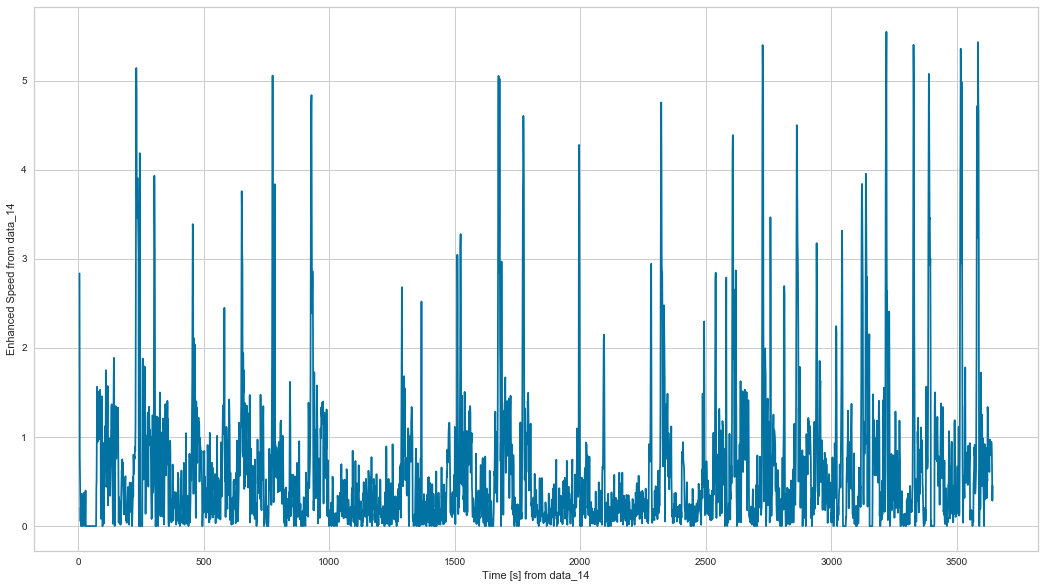

In [200]:
##Graph results: 
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

print("Plotting...")
#x = das_14_time
#y = speed_14_array

#avg_time_array.pop(-1)
#avg_speed_array.pop(-1)

x = avg_time_array
y = avg_speed_array

#x_ticks = np.arange([])
#y_ticks = np.arange([])

plt.figure(figsize=(18,10))

plt.plot(x,y)
plt.xlabel('Time [s] from data_14')
plt.ylabel('Enhanced Speed from data_14')
#frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels(x_ticks)
#frame1.axes.yaxis.set_ticklabels(y_ticks)

plt.show()

## Footage sync code written by Alina:

In [283]:
#Footage sync code written by Alina: (Miulti-Column)

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #----Complex "mode" below: --------
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

In [284]:
motion_df_simple = label_data('Footage3.txt')
motion_df_simple.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789        0.0                  0      NaN   
        2018-11-09 19:16:04.053      252.5                  0      NaN   
        2018-11-09 19:16:04.284      501.5                  0      NaN   
        2018-11-09 19:16:04.548      753.5                  0      NaN   
        2018-11-09 19:16:04.812     1003.5                  1      NaN   
        2018-11-09 19:16:05.043     1253.5                  1      NaN   
        2018-11-09 19:16:05.307     1504.5                  1      NaN   
        2018-11-09 19:16:05.571     1755.5                  1      NaN   
        2018-11-09 19:16:05.802     2006.5                  2      NaN   
        2018-11-09 19:16:06.066     2258.5                  2      NaN   

                                 WALKING  FLOATING  SURFING  PADDLING  
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0         0        0         0  
        2018-11-09 19:16:04.053        0         0        0         0  
        2018-11-09 19:16:04.284        0         0        0         0  
        2018-11-09 19:16:04.548        0         0        0         0  
        2018-11-09 19:16:04.812        0         0        0         0  
        2018-11-09 19:16:05.043        0         0        0         0  
        2018-11-09 19:16:05.307        0         0        0         0  
        2018-11-09 19:16:05.571        0         0        0         0  
        2018-11-09 19:16:05.802        0         0        0         0  
        2018-11-09 19:16:06.066        0         0        0         0

In [285]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:03.789        0.0                  0      NaN   
        2018-11-09 19:16:04.053      252.5                  0      NaN   
        2018-11-09 19:16:04.284      501.5                  0      NaN   
        2018-11-09 19:16:04.548      753.5                  0      NaN   
        2018-11-09 19:16:04.812     1003.5                  1      NaN   
        2018-11-09 19:16:05.043     1253.5                  1      NaN   
        2018-11-09 19:16:05.307     1504.5                  1      NaN   
        2018-11-09 19:16:05.571     1755.5                  1      NaN   
        2018-11-09 19:16:05.802     2006.5                  2      NaN   
        2018-11-09 19:16:06.066     2258.5                  2      NaN   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789                         0   
        2018-11-09 19:16:04.053                         0   
        2018-11-09 19:16:04.284                         0   
        2018-11-09 19:16:04.548                         0   
        2018-11-09 19:16:04.812                         0   
        2018-11-09 19:16:05.043                         0   
        2018-11-09 19:16:05.307                         0   
        2018-11-09 19:16:05.571                         0   
        2018-11-09 19:16:05.802                         0   
        2018-11-09 19:16:06.066                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:1

In [286]:
## Drop all of the NaN values from columns (NaN due to velocity input feature): 
motion_df_simple = motion_df_simple[motion_df_simple.Velocity != "NaN"]
motion_df_complex = motion_df_complex[motion_df_complex.Velocity != "NaN"]

#motion_df_simple.head(10)
#motion_df_complex.head(10)

## Concatenate multiple footage files that we have so far to create a larger mass of data samples. 

In [287]:
df1_complex = label_data('Footage.txt', 'complex')
df2_complex = label_data('Footage2.txt', 'complex')
df3_complex = label_data('Footage3.txt', 'complex')
df4_complex = label_data('Footage4.txt', 'complex')

df_concatenated = pd.concat([df1_complex, df2_complex, df3_complex, df4_complex])

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
#print(df1_complex.head(10))
print(df_concatenated.head(10))

Shape of first dataframe: (21645, 35)
Shape of all combined dataframes: (86580, 62)
Printing dataframe...
                                 BOARD FLIPPED RIGHT SIDE UP  \
ride_id UTC                                                    
15692   2018-11-09 19:16:03.789                          NaN   
        2018-11-09 19:16:04.053                          NaN   
        2018-11-09 19:16:04.284                          NaN   
        2018-11-09 19:16:04.548                          NaN   
        2018-11-09 19:16:04.812                          NaN   
        2018-11-09 19:16:05.043                          NaN   
        2018-11-09 19:16:05.307                          NaN   
        2018-11-09 19:16:05.571                          NaN   
        2018-11-09 19:16:05.802                          NaN   
        2018-11-09 19:16:06.066                          NaN   

                                 BOARD FLIPPED UPSIDE DOWN (TO SYNC)  \
ride_id UTC                                          

/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [288]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= -0.019141  #forwards/backwards
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141   #upside down/right side up
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141   #sideways: negative = left, positive = right
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2        #roll
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2        #yaw
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2        #pitch (flipping forwards/backwards)

motion_df_complex.head(10)    


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:33.984  1.414773e+09     1.0   543.0    81.0   -20.0   
        2018-11-09 19:16:34.248  1.414773e+09   -58.0   511.0    64.0   -28.0   
        2018-11-09 19:16:34.479  1.414773e+09   -44.0   451.0    85.0    46.0   
        2018-11-09 19:16:34.743  1.414774e+09   -44.0   473.0   113.0   -61.0   
        2018-11-09 19:16:34.974  1.414774e+09   -17.0   511.0    76.0    64.0   
        2018-11-09 19:16:35.238  1.414774e+09  -191.0   406.0    74.0     2.0   
        2018-11-09 19:16:35.502  1.414774e+09     0.0   553.0    31.0   202.0   
        2018-11-09 19:16:35.733  1.414775e+09   -53.0   571.0   -61.0  -246.0   
        2018-11-09 19:16:35.997  1.414775e+09   -88.0   483.0    82.0   -20.0   
        2018-11-09 19:16:36.228  1.414775e+09   -23.0   416.0   138.0   174.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:33.984    -6.0    42.0   -38.0  -164.0   208.0   
        2018-11-09 19:16:34.248   -15.0   -27.0   -47.0  -163.0   205.0   
        2018-11-09 19:16:34.479     7.0   -46.0   -42.0  -162.0   196.0   
        2018-11-09 19:16:34.743    18.0   -38.0   -30.0  -156.0   196.0   
        2018-11-09 19:16:34.974    51.0    31.0   -35.0  -167.0   197.0   
        2018-11-09 19:16:35.238    15.0   138.0   -30.0  -160.0   210.0   
        2018-11-09 19:16:35.502   136.0   171.0   -54.0  -162.0   212.0   
        2018-11-09 19:16:35.733   203.0    64.0   -83.0  -159.0   215.0   
        2018-11-09 19:16:35.997   127.0   -77.0   -95.0  -173.0   199.0   
        2018-11-09 19:16:36.228    35.0   -99.0   -79.0  -155.0   213.0   

                                 TimeDelta  TimeDelta_seconds Velocity  \
ride_id UTC                                                              
15692   2018-11-09 19:16:33.984    30005.5                 30    2.837   
        2018-11-09 19:16:34.248    30257.5                 30    2.837   
        2018-11-09 19:16:34.479    30507.5                 30    2.837   
        2018-11-09 19:16:34.743    30758.5                 30    2.837   
        2018-11-09 19:16:34.974    31008.5                 31   0.7903   
        2018-11-09 19:16:35.238    31259.5                 31   0.7903   
        2018-11-09 19:16:35.502    31511.5                 31   0.7903   
        2018-11-09 19:16:35.733    31761.5                 31   0.7903   
        2018-11-09 19:16:35.997    32004.5                 32   0.5416   
        2018-11-09 19:16:36.228    32252.5                 32   0.5416   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:33.984                         1   
        2018-11-09 19:16:34.248                         1   
        2018-11-09 19:16:34.479                         1   
        2018-11-09 19:16:34.743                         1   
        2018-11-09 19:16:34.974                         1   
        2018-11-09 19:16:35.238                         1   
        2018-11-09 19:16:35.502                         1   
        2018-11-09 19:16:35.733                         1   
        2018-11-09 19:16:35.997                         1   
        2018-11-09 19:16:36.228                         1   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:33.984                                                  0    
        2018-11-09 19:16:34.248                                                  0    
        2018-11-09 19:16:34.479                                                  0    
        2018-11-09 19:16:34.743                                                  0    
        2018-11-09 19:1

In [289]:
df_converted.head(10)

Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:33.984  1.414773e+09 -0.019141  10.393563  1.550421   
        2018-11-09 19:16:34.248  1.414773e+09  1.110178   9.781051  1.225024   
        2018-11-09 19:16:34.479  1.414773e+09  0.842204   8.632591  1.626985   
        2018-11-09 19:16:34.743  1.414774e+09  0.842204   9.053693  2.162933   
        2018-11-09 19:16:34.974  1.414774e+09  0.325397   9.781051  1.454716   
        2018-11-09 19:16:35.238  1.414774e+09  3.655931   7.771246  1.416434   
        2018-11-09 19:16:35.502  1.414774e+09 -0.000000  10.584973  0.593371   
        2018-11-09 19:16:35.733  1.414775e+09  1.014473  10.929511 -1.167601   
        2018-11-09 19:16:35.997  1.414775e+09  1.684408   9.245103  1.569562   
        2018-11-09 19:16:36.228  1.414775e+09  0.440243   7.962656  2.641458   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:33.984  -2.439024  -0.731707   5.121951   -38.0   
        2018-11-09 19:16:34.248  -3.414634  -1.829268  -3.292683   -47.0   
        2018-11-09 19:16:34.479   5.609756   0.853659  -5.609756   -42.0   
        2018-11-09 19:16:34.743  -7.439024   2.195122  -4.634146   -30.0   
        2018-11-09 19:16:34.974   7.804878   6.219512   3.780488   -35.0   
        2018-11-09 19:16:35.238   0.243902   1.829268  16.829268   -30.0   
        2018-11-09 19:16:35.502  24.634146  16.585366  20.853659   -54.0   
        2018-11-09 19:16:35.733 -30.000000  24.756098   7.804878   -83.0   
        2018-11-09 19:16:35.997  -2.439024  15.487805  -9.390244   -95.0   
        2018-11-09 19:16:36.228  21.219512   4.268293 -12.073171   -79.0   

                                 IMU M2  IMU M3  TimeDelta  TimeDelta_seconds  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:33.984  -164.0   208.0    30005.5                 30   
        2018-11-09 19:16:34.248  -163.0   205.0    30257.5                 30   
        2018-11-09 19:16:34.479  -162.0   196.0    30507.5                 30   
        2018-11-09 19:16:34.743  -156.0   196.0    30758.5                 30   
        2018-11-09 19:16:34.974  -167.0   197.0    31008.5                 31   
        2018-11-09 19:16:35.238  -160.0   210.0    31259.5                 31   
        2018-11-09 19:16:35.502  -162.0   212.0    31511.5                 31   
        2018-11-09 19:16:35.733  -159.0   215.0    31761.5                 31   
        2018-11-09 19:16:35.997  -173.0   199.0    32004.5                 32   
        2018-11-09 19:16:36.228  -155.0   213.0    32252.5                 32   

                                Velocity  PUSHING BOARD INTO WATER  \
ride_id UTC                                                          
15692   2018-11-09 19:16:33.984    2.837                         1   
        2018-11-09 19:16:34.248    2.837                         1   
        2018-11-09 19:16:34.479    2.837                         1   
        2018-11-09 19:16:34.743    2.837                         1   
        2018-11-09 19:16:34.974   0.7903                         1   
        2018-11-09 19:16:35.238   0.7903                         1   
        2018-11-09 19:16:35.502   0.7903                         1   
        2018-11-09 19:16:35.733   0.7903                         1   
        2018-11-09 19:16:35.997   0.5416                         1   
        2018-11-09 19:16:36.228   0.5416                         1   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:33.984                                                  0    
        2018-11-09 19:16:34.248                                                  0    
     

In [290]:
list(df_converted)

['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'TimeDelta',
 'TimeDelta_seconds',
 'Velocity',
 'PUSHING BOARD INTO WATER',
 'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)',
 'FLIP BOARD RIGHT SIDE UP',
 'WALKING IN WATER',
 'PUSH-OFF',
 'PADDLING INTO WAVES',
 'SIT-UP',
 'FLOATING',
 "TURNING TO SURFER'S LEFT",
 'LAY-DOWN',
 'PADDLING FOR A WAVE',
 'POP-UP',
 'SURFING',
 'STEP-OFF',
 "TURNING TO SURFER'S RIGHT",
 'SIT-BACK',
 'OFF-BOARD',
 'PADDLING',
 'WIPE-OUT',
 'PULL-BACK LEASH',
 'PADDLING FOR POSITION',
 'NEW',
 'DONE, OUT OF WATER',
 'WALKING OUT OF WATER']

In [291]:
## Drop data columns that we don't care about predicting/visualizing: 
df_converted = df_converted.drop(columns=["FLIP BOARD RIGHT SIDE UP", "NEW", "DONE, OUT OF WATER"])
#df_converted = df_converted.drop(columns!=["SURFING, FLOATING, PADDLING INTO WAVES, PADDLING FOR A WAVE, PADDLING FOR POSITION, PADDLING"])

## Plot IMU Signals with Labels:

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after Velocity
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('Velocity') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'lower left')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        #file_name = column
        #pdf_string = '.jpg'
        #file_name += pdf_string
        
        #plt.savefig(file_name)
        plt.show()
        
        return 

Creating Plots...


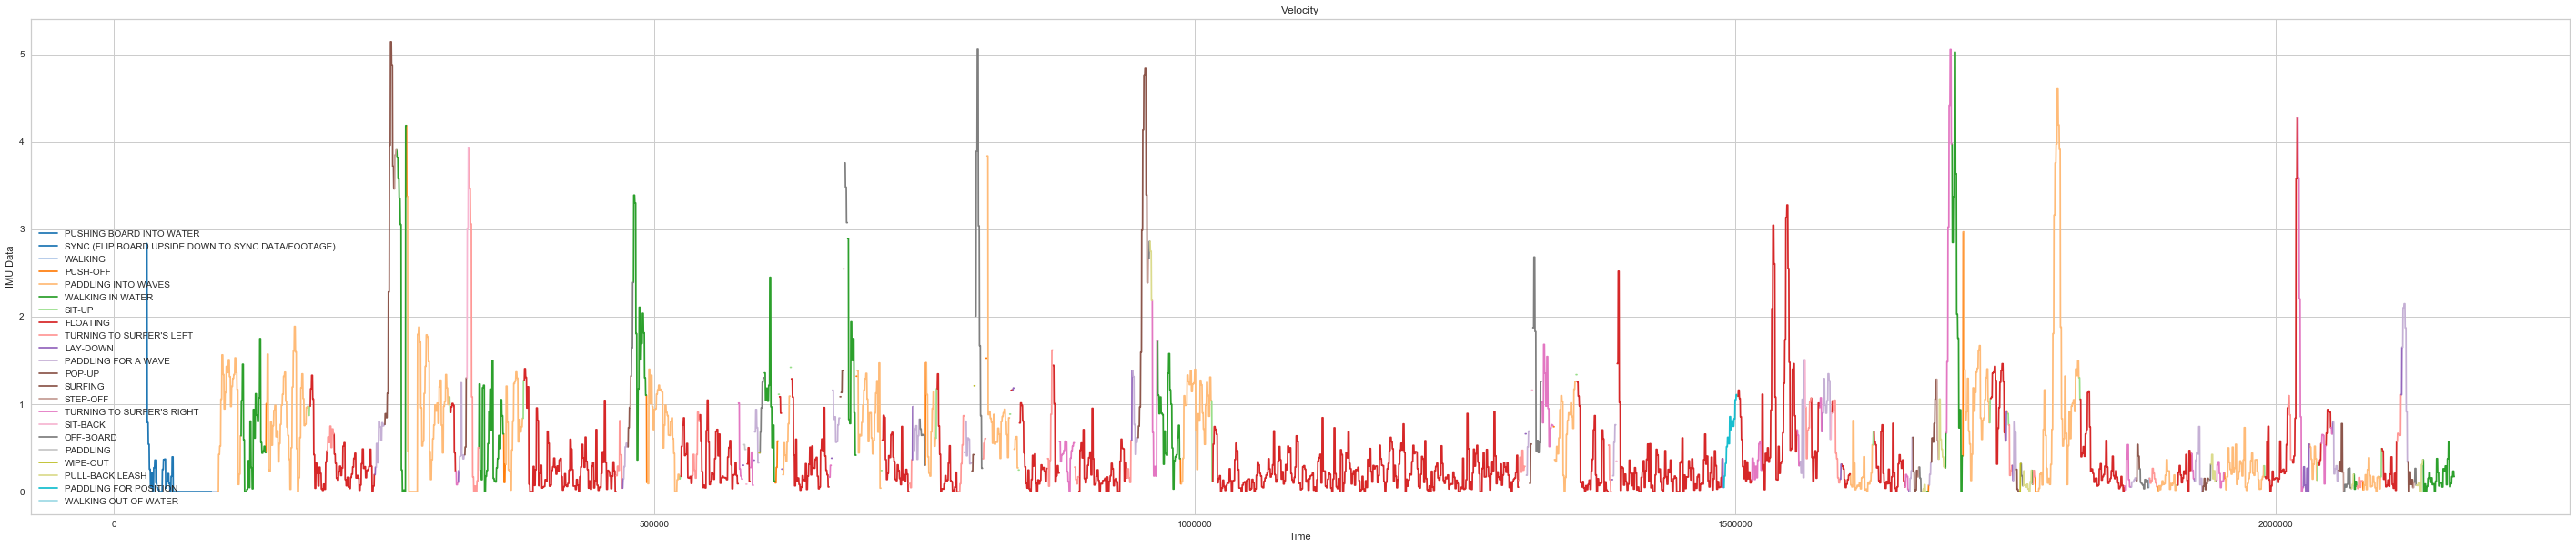

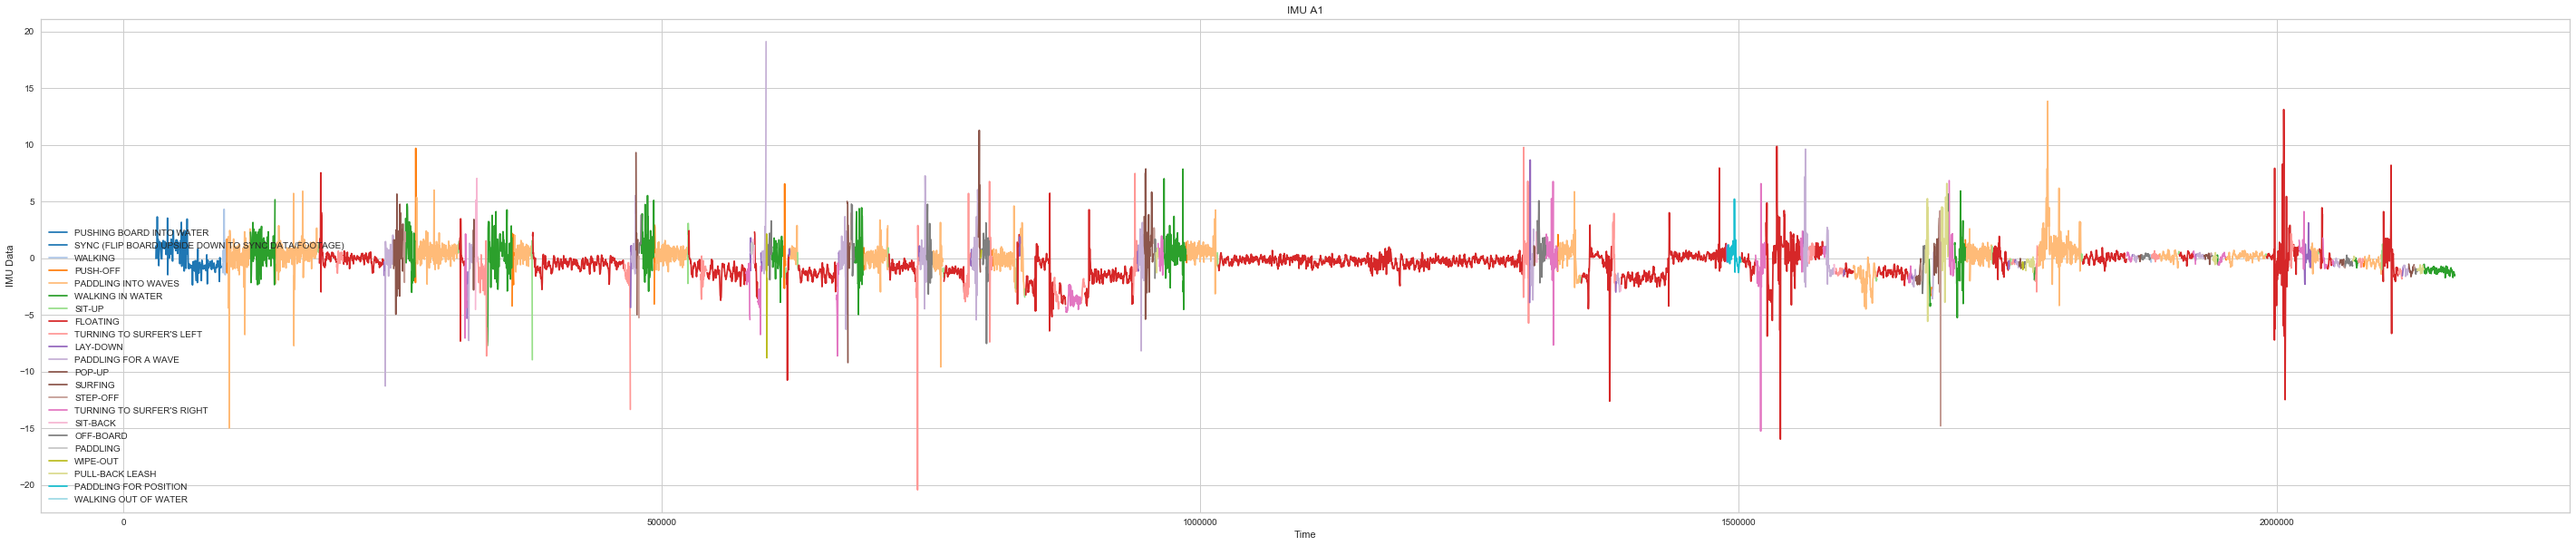

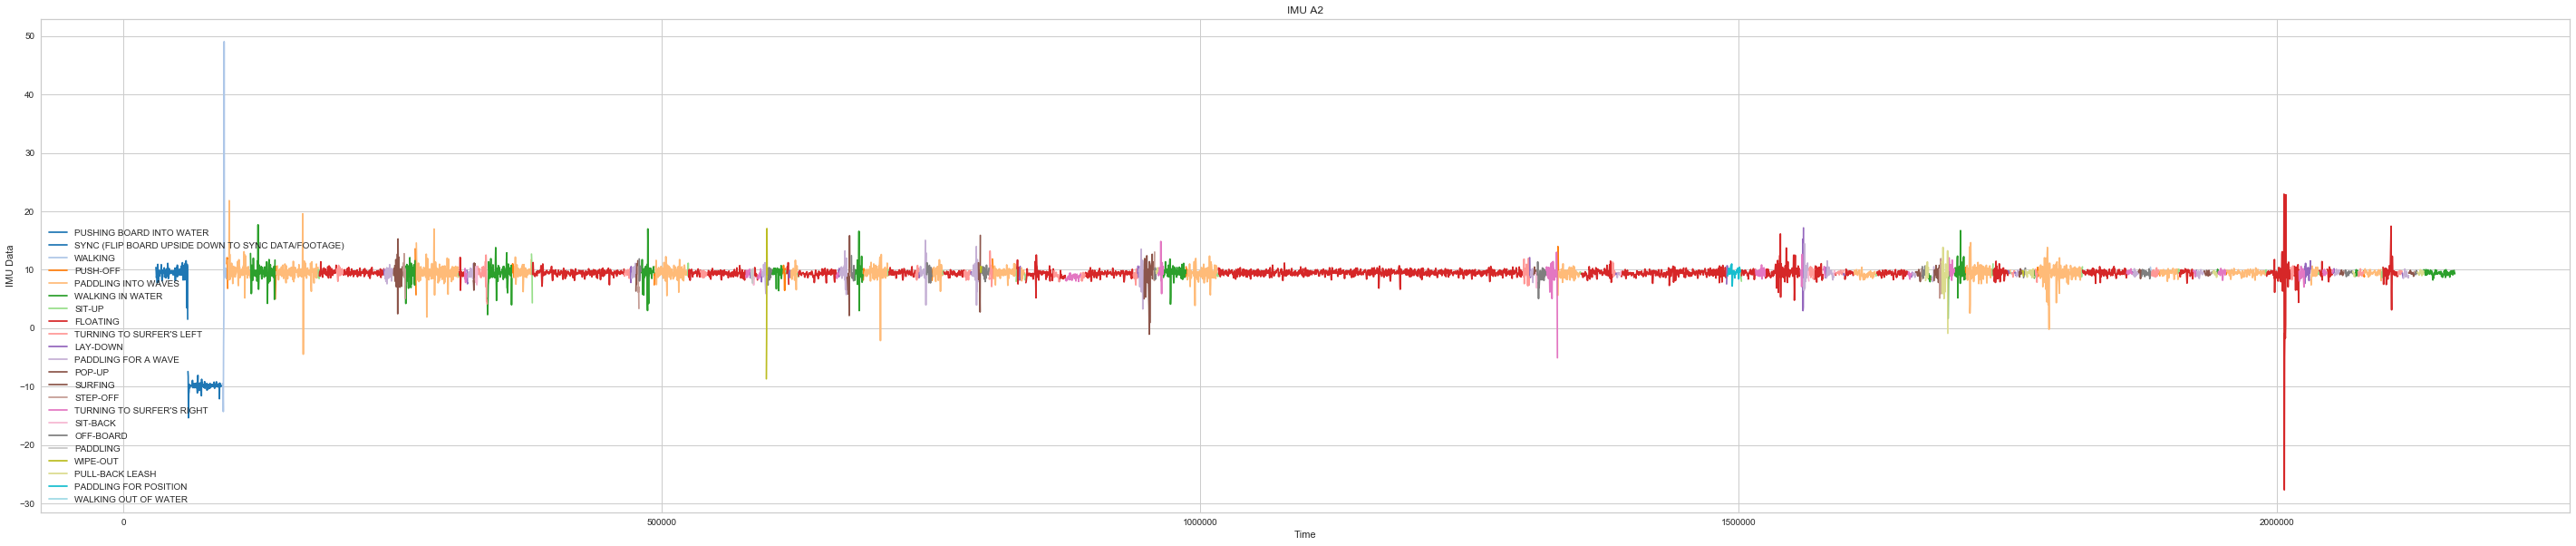

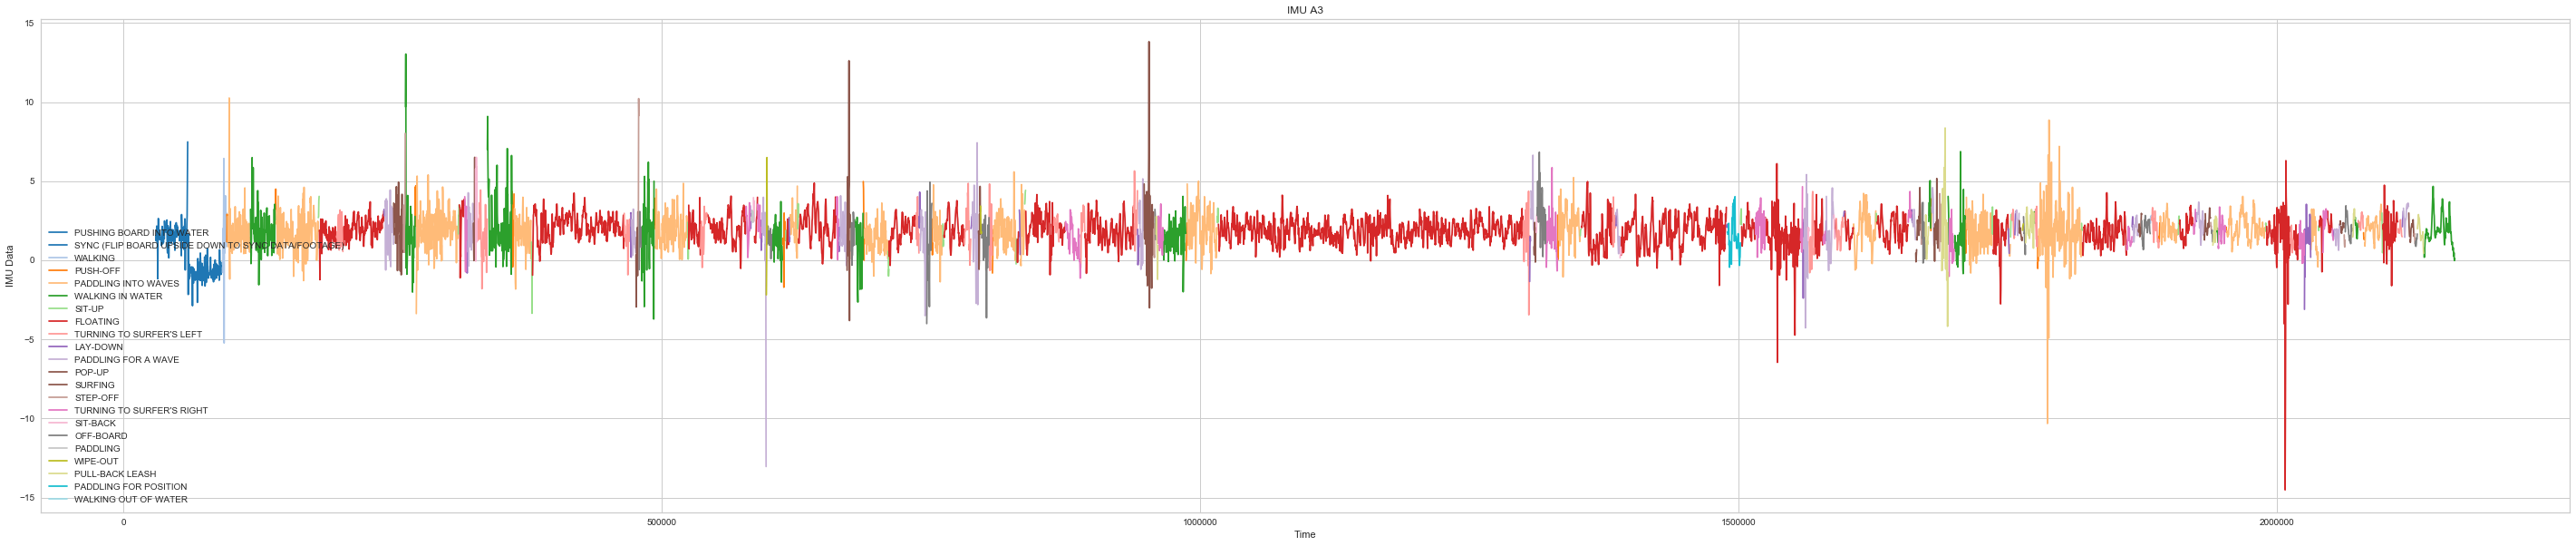

Done


In [212]:
#For plotting, just comment out the "concatenation" lines. 

#Need to clear kernel and then only run all above so that it plots on axes directly below, rather than on another plot
print("Creating Plots...")
createPlot(df_converted,'Velocity')
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
#createPlot(df_converted,'IMU G1')
#createPlot(df_converted,'IMU G2')
#createPlot(df_converted,'IMU G3')
#createPlot(df_converted,'IMU M1')
#createPlot(df_converted,'IMU M2')
#createPlot(df_converted,'IMU M3')

print("Done")


## Butterworth Bandpass Filter

Plotting:


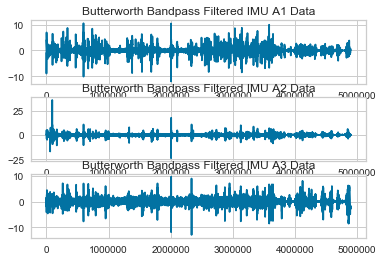

The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...


In [160]:
## Apply a Filter to the signals to reduce noise:
## Butter Filters for Bandpass:
%matplotlib inline
from scipy import signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
#fs = 30
fs = 5
lowcut = 0.0333
highcut = 1.5


#Get each IMU column from the dataframe: 
#array = df_converted.values

time_array = df_converted['TimeDelta'].values
imua1_array = df_converted['IMU A1'].values
imua2_array = df_converted['IMU A2'].values
imua3_array = df_converted['IMU A3'].values

imug1_array = df_converted['IMU G1'].values
imug2_array = df_converted['IMU G2'].values
imug3_array = df_converted['IMU G3'].values

imum1_array = df_converted['IMU M1'].values
imum2_array = df_converted['IMU M2'].values
imum3_array = df_converted['IMU M3'].values


##Graphing the bandpass filters:
#A bandpass filter is both a highpass and a lowpass filter combined.
butter_lfilter_a1 = butter_bandpass_lfilter(imua1_array, lowcut, highcut, fs, order=5)
butter_lfilter_a2 = butter_bandpass_lfilter(imua2_array, lowcut, highcut, fs, order=5)
butter_lfilter_a3 = butter_bandpass_lfilter(imua3_array, lowcut, highcut, fs, order=5)



#butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)



#Can change num_elems to 1000 for example if you only want to graph the first 1000 elems:
num_elems = len(time_array)

print("Plotting:")
plt.figure(1)
plt.subplot(311)
plt.plot(time_array[:num_elems], butter_lfilter_a1[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A1 Data")

plt.subplot(312)
plt.plot(time_array[:num_elems], butter_lfilter_a2[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A2 Data")

plt.subplot(313)
plt.plot(time_array[:num_elems], butter_lfilter_a3[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A3 Data")

#Save as file
file_name = "butter_worth_graphs"
pdf_string = '.jpg'
file_name += pdf_string
plt.savefig(file_name)

#Show in line
plt.show()

print("The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...")

### Filtering data with a butterworth filter, then plotting in 2D: 

In [142]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = imua1_array
y = imug1_array
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('IMU A1')
plt.ylabel('IMU G3')
plt.show()
print("Done")

NameError: name 'imua1_array' is not defined

## Update dataframe with the filtered values, then do another labelled plot of all IMU values: 

## Binary Logistic Regression Model on Raw data values: 

In [292]:
## Make sure that the df_converted that gets copied does not get changed by the filtering methods being tested.
dataset = df_converted.copy()

print(dataset.head(100))

                                         Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:33.984  1.414773e+09 -0.019141  10.393563  1.550421   
        2018-11-09 19:16:34.248  1.414773e+09  1.110178   9.781051  1.225024   
        2018-11-09 19:16:34.479  1.414773e+09  0.842204   8.632591  1.626985   
        2018-11-09 19:16:34.743  1.414774e+09  0.842204   9.053693  2.162933   
        2018-11-09 19:16:34.974  1.414774e+09  0.325397   9.781051  1.454716   
        2018-11-09 19:16:35.238  1.414774e+09  3.655931   7.771246  1.416434   
        2018-11-09 19:16:35.502  1.414774e+09 -0.000000  10.584973  0.593371   
        2018-11-09 19:16:35.733  1.414775e+09  1.014473  10.929511 -1.167601   
        2018-11-09 19:16:35.997  1.414775e+09  1.684408   9.245103  1.569562   
        2018-11-09 19:16:36.228  1.414775e+09  0.440243   7.962656  2.641458   
        2018-11-09 19:16:36.492  1.41477

In [293]:
print(dataset.columns)

Index(['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3',
       'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'TimeDelta_seconds',
       'Velocity', 'PUSHING BOARD INTO WATER',
       'SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)',
       'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP',
       'FLOATING', 'TURNING TO SURFER'S LEFT', 'LAY-DOWN',
       'PADDLING FOR A WAVE', 'POP-UP', 'SURFING', 'STEP-OFF',
       'TURNING TO SURFER'S RIGHT', 'SIT-BACK', 'OFF-BOARD', 'PADDLING',
       'WIPE-OUT', 'PULL-BACK LEASH', 'PADDLING FOR POSITION',
       'WALKING OUT OF WATER'],
      dtype='object')


In [337]:
#Link which explains below: 
#https://stackoverflow.com/questions/37512079/python-pandas-why-does-df-iloc-1-values-for-my-training-data-select-till
X = dataset.iloc[:, :11].values  #selects everything until the last column listed (in this case, the 0-10 columns get taken)
#TURNING TO SURFER\'S RIGHT
y = dataset.loc[:,'SURFING'].values   #selects the column specified (ex: 'FLOATING')
print("X.shape:", X.shape)
print("y.shape:", y.shape)


#What is the column heading of the y column given? 
print(dataset.iloc[0][-1])

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("first few y_train values:", y_train[0:10])
print("first few y_test values:", y_test[0:10])

#The y-axis is currently set to the 19th frame ("FLOATING").

X_train_res = X_train
y_train_res = y_train

X.shape: (15560, 11)
y.shape: (15560,)
0
x_train shape: (14004, 11)
y_train shape: (14004,)
x_test shape: (1556, 11)
y_test shape: (1556,)
first few y_train values: [0 0 0 0 0 0 0 0 0 0]
first few y_test values: [0 0 0 0 0 0 0 0 0 0]


In [338]:
#May need to use SMOTE technique to balance the data more equally (so majority class i.e. 0 doesn't dominate).
#SMOTE explanation: http://rikunert.com/SMOTE_explained
#Example code: https://beckernick.github.io/oversampling-modeling/

from imblearn.over_sampling import SMOTE, ADASYN


sm = SMOTE(random_state=12, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets


#Use SMOTE to balance the training sets: 
#X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

#OR use ADASYN to balance the training sets: 
#X_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)

In [339]:
# Fit into Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X=X_train_res, y=y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [340]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

# Predicting the Test set results
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

#print("Printing every y in y_test:")
#for y in y_test:
#    print(y)
#print(y_test)

print(y_pred[0:500]) #just checking to make sure that it's actually guessing (not just always 0)

[[896 644]
 [ 12   4]]
[0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1
 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0
 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0
 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0
 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1
 0

In [344]:
#Make a prettier looking confusion matrix using yellowbrick visualizers: 

cm = ConfusionMatrix(classifier, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_res, y_train_res)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
#cm.poof()


0.5784061696658098

In [342]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
print(score)

[0.51770231 0.51011561 0.49313584 0.4949422  0.49783237 0.4974711
 0.50036127 0.50216763 0.48553868 0.50289226]


In [343]:
avg = 0.0
for s in score: 
    avg += s
avg = avg/10.0
print(avg)

0.5002159270915618


## Training Multiple Binary Logistic Regression Models

In [222]:
#Create one for surfing, paddling, floating, etc. all trained on same training data

#For each point in the "test" category, determine the probability that it is floating/paddling/surfing

#Choose the model that gives the highest probability 



## Setting up dataframe for Single Multinomial Logistic Regression Model
### Footage sync code: (Single-Column, Multi-Class)

In [238]:
#Copy the converted dataset, keep the features, and create only one column that contains labels. 

print("Creating multiclass dataframe...")

#Can also add "UTC Time" and "Time Delta" columns if needed later. 
multiclass_df = df_converted[['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', "Velocity"]].copy()
parse_df = df_converted.copy()

print(multiclass_df.head(10))
      
    
#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
print(parse_df.head(100))


#Drop the 2nd column of parse_df (which has all NaN values)
cols = [1]
parse_df.drop(parse_df.columns[cols],axis=1,inplace=True)
parse_df.columns=['complex_label']
#print(parse_df.head(100))


#Concatenate the parse column with the multiclass dataframe. 
multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)
#print(multiclass_df.head(100))

#Drop the NaN rows from the beginning/end of the df.
print("Shape before dropping NA:", multiclass_df.shape)
multiclass_df = multiclass_df.dropna()
print("Shape after dropping NA:", multiclass_df.shape)
print(multiclass_df.head(10))


complex_multiclass_df = multiclass_df.copy()
print("\n Done creating complex multiclass df.")


Creating multiclass dataframe...
                                   IMU A1     IMU A2    IMU A3     IMU G1  \
ride_id UTC                                                                 
15692   2018-11-09 19:16:33.984 -0.019141  10.393563  1.550421  -2.439024   
        2018-11-09 19:16:34.248  1.110178   9.781051  1.225024  -3.414634   
        2018-11-09 19:16:34.479  0.842204   8.632591  1.626985   5.609756   
        2018-11-09 19:16:34.743  0.842204   9.053693  2.162933  -7.439024   
        2018-11-09 19:16:34.974  0.325397   9.781051  1.454716   7.804878   
        2018-11-09 19:16:35.238  3.655931   7.771246  1.416434   0.243902   
        2018-11-09 19:16:35.502 -0.000000  10.584973  0.593371  24.634146   
        2018-11-09 19:16:35.733  1.014473  10.929511 -1.167601 -30.000000   
        2018-11-09 19:16:35.997  1.684408   9.245103  1.569562  -2.439024   
        2018-11-09 19:16:36.228  0.440243   7.962656  2.641458  21.219512   

                                    IMU G2

### Create Simplified Multiclass Labels

In [239]:
#Create simple multiclass df: (Surfing, Floating, Paddling, Misc.)

simple_multiclass_df = multiclass_df.copy()

simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('SURFING|PADDLING|FLOATING|POP-UP')==False, 'complex_label'] = 'MISC'
simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('PADDLING'), 'complex_label'] = 'PADDLING'

##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('POP-UP'), 'complex_label'] = 'SURFING'
##simple_multiclass_df.loc[simple_multiclass_df['complex_label'].str.contains('TURNING'), 'complex_label'] = 'FLOATING'


column_names = list(simple_multiclass_df)
column_names = column_names[:-1]
column_names.append("simple_label")

print(column_names)
simple_multiclass_df.columns=column_names

print(simple_multiclass_df.head(5))

simple_misc_multiclass_df = simple_multiclass_df.copy()

#Check to see that labels exist: 
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['simple_label'].str.match('FLOATING|PADDLING|SURFING')]

print(simple_multiclass_df.head(5))


['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'Velocity', 'simple_label']
                                   IMU A1     IMU A2    IMU A3    IMU G1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:33.984 -0.019141  10.393563  1.550421 -2.439024   
        2018-11-09 19:16:34.248  1.110178   9.781051  1.225024 -3.414634   
        2018-11-09 19:16:34.479  0.842204   8.632591  1.626985  5.609756   
        2018-11-09 19:16:34.743  0.842204   9.053693  2.162933 -7.439024   
        2018-11-09 19:16:34.974  0.325397   9.781051  1.454716  7.804878   

                                   IMU G2    IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                   
15692   2018-11-09 19:16:33.984 -0.731707  5.121951   -38.0  -164.0   208.0   
        2018-11-09 19:16:34.248 -1.829268 -3.292683   -47.0  -163.0   205.0   
        2018-11-09 19:16:34.479 

## Visualizing raw multinomial data: 

### Need to run the %matplotlib notebook cells 2-3x in a row to get proper display:

['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
6688


<IPython.core.display.Javascript object>


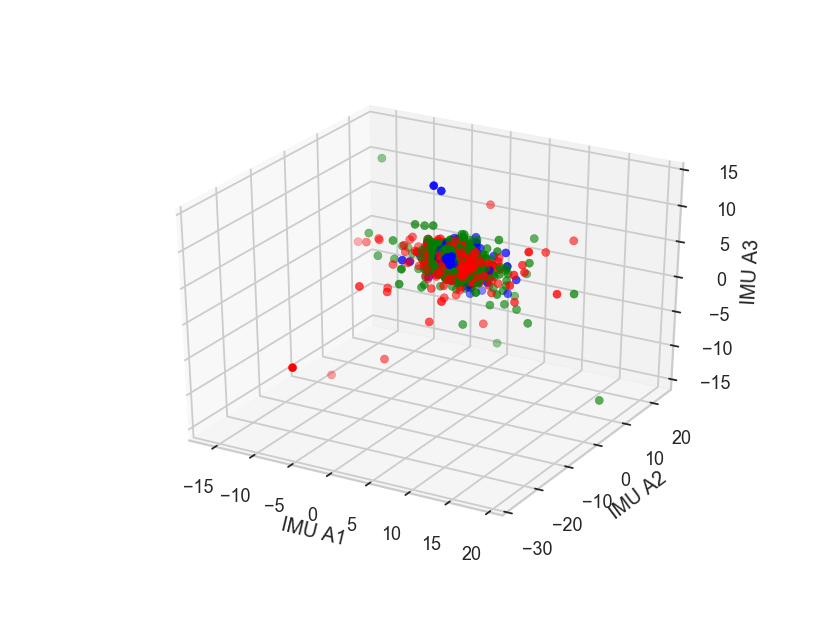

In [253]:
##Visualizing the data in 3d. 

%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

data = simple_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")
        
#print(colors)



td_plot = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot.scatter(data['IMU A1'], data['IMU A2'], data['IMU A3'], c=colors)
#td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'])
td_plot.set_xlabel('IMU A1')
td_plot.set_ylabel('IMU A2')
td_plot.set_zlabel('IMU A3')
plt.show()

Plotting...


<IPython.core.display.Javascript object>


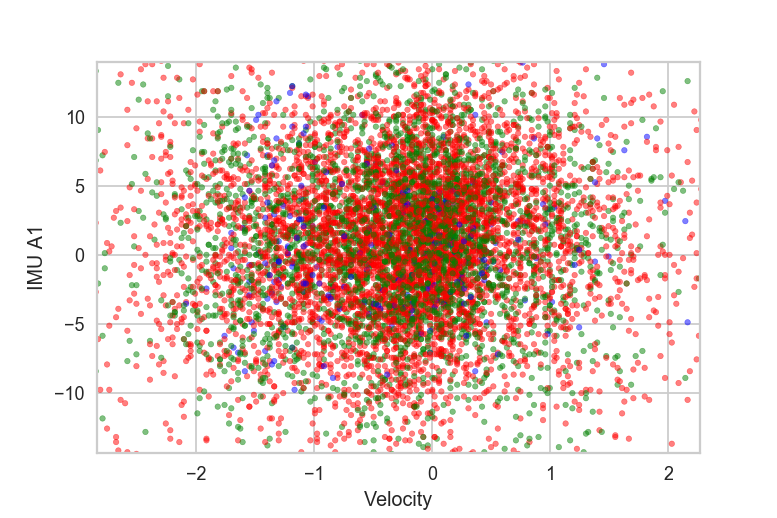

Done


In [264]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('Velocity')
plt.ylabel('IMU A1')
#plt.ylabel('IMU G3')
plt.show()
print("Done")


['MISC' 'MISC' 'MISC' ... 'MISC' 'MISC' 'MISC']
9327


<IPython.core.display.Javascript object>


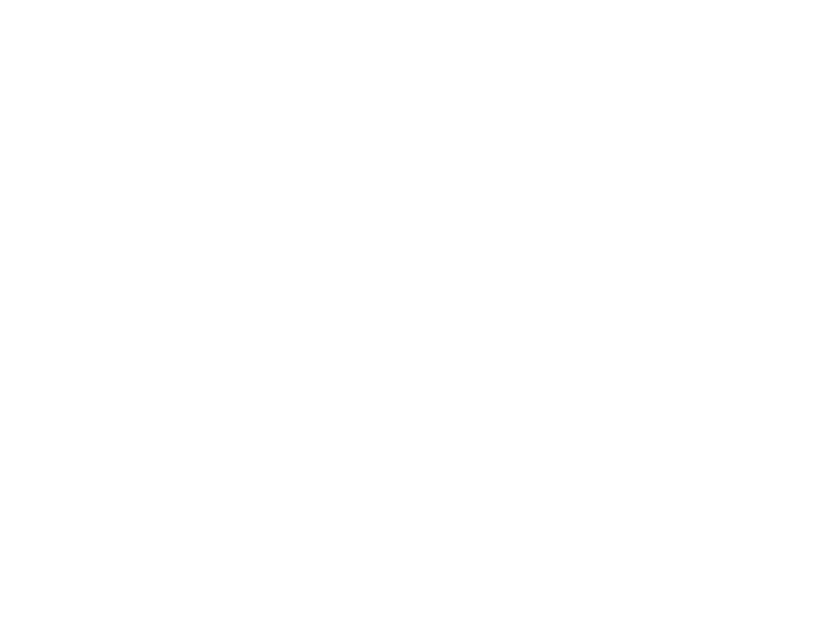

In [268]:
#Same visualization as above but including MISC values. 
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

data = simple_misc_multiclass_df.copy()

data_y = data.loc[:,'simple_label'].values
#y = y.tolist()
print(data_y)

n = len(data_y)
print(n)

colors = []
for i in range(0,n):
    if data_y[i] == 'MISC': 
        colors.append("red")
    if data_y[i] == 'PADDLING':
         colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("yellow")
        
#print(colors)



td_plot = plt.figure(figsize=[6.4, 4.8]).gca(projection='3d')
td_plot.scatter(data['IMU A1'], data['IMU A2'], data['IMU A3'], c=colors)
#td_plot.scatter(data['IMU G1'], data['IMU G2'], data['IMU G3'])
td_plot.set_xlabel('IMU A1')
td_plot.set_ylabel('IMU A2')
td_plot.set_zlabel('IMU A3')
plt.show()

Plotting...


<IPython.core.display.Javascript object>


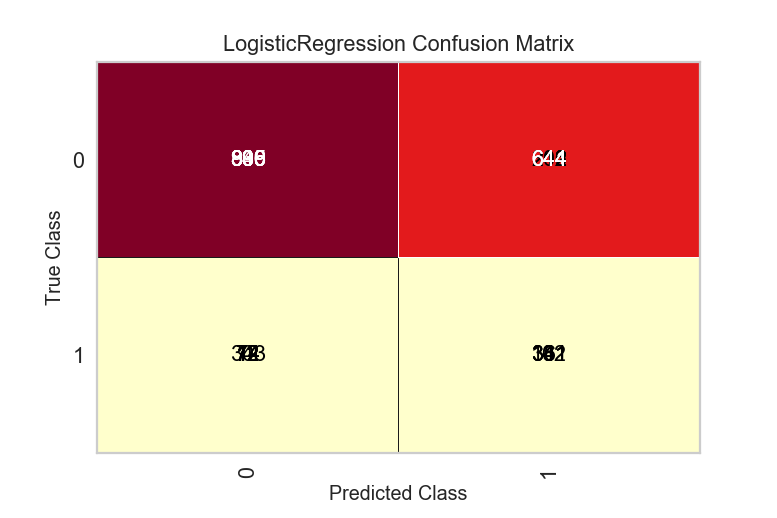

Done


In [270]:
## 2D scatterplots: 
%matplotlib notebook
import matplotlib.pyplot as plt

# Create data
x = data['IMU A1']
y = data['IMU G3']
area = np.pi*3

colors = []
no_misc = []
for i in range(0,n):
    #if data_y[i] == 'MISC': 
        #colors.append("yellow")
    #if data_y[i] == 'PADDLING':
         #colors.append("green")
    if data_y[i] == 'SURFING': 
        colors.append("blue")
    if data_y[i] == 'FLOATING': 
        colors.append("red")
    #if data_y[i] == 'MISC':
        #colors.append("yellow")

# Plot
print("Plotting...")
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#plt.title('')
plt.xlabel('Velocity')
plt.ylabel('IMU A1')
#plt.ylabel('IMU G3')
plt.show()
print("Done")


## Pre-Processing Steps for Multinomial Logistic Regression

In [244]:
#If we don't want to include MISC values: 
simple_multi_dataset = simple_multiclass_df.copy()
print(simple_multi_dataset.columns)

#If we do want to include MISC values: 
#simple_multi_dataset = simple_misc_multiclass_df.copy()

Index(['IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1',
       'IMU M2', 'IMU M3', 'Velocity', 'simple_label'],
      dtype='object')


In [245]:
#Need to scale all feature values



In [246]:
#Need to split into testing and training sets

X = simple_multi_dataset.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_multi_dataset.iloc[:, -1].values   #selects the last column 

#X = simple_misc_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
#y = simple_misc_multiclass_df.iloc[:, -1].values   #selects the last column 


print("X.shape:", X.shape)
print("y.shape:", y.shape)

print("y:", y)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y_val in y: 
    if y_val == "FLOATING":
        count_y_float+=1
    if y_val == "PADDLING":
        count_y_paddle+=1
    if y_val == "SURFING":
        count_y_surf+=1

print("Num floating: ", count_y_float)
print("Num paddling: ", count_y_paddle)
print("Num surfing: ", count_y_surf)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#print("first few y_train values:", y_train[0:10])
#print("first few y_test values:", y_test[0:10])



X.shape: (6688, 10)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
Num floating:  4312
Num paddling:  2196
Num surfing:  180
x_train shape: (6019, 10)
y_train shape: (6019,)
x_test shape: (669, 10)
y_test shape: (669,)


### Setting up the dataset: 

<IPython.core.display.Javascript object>


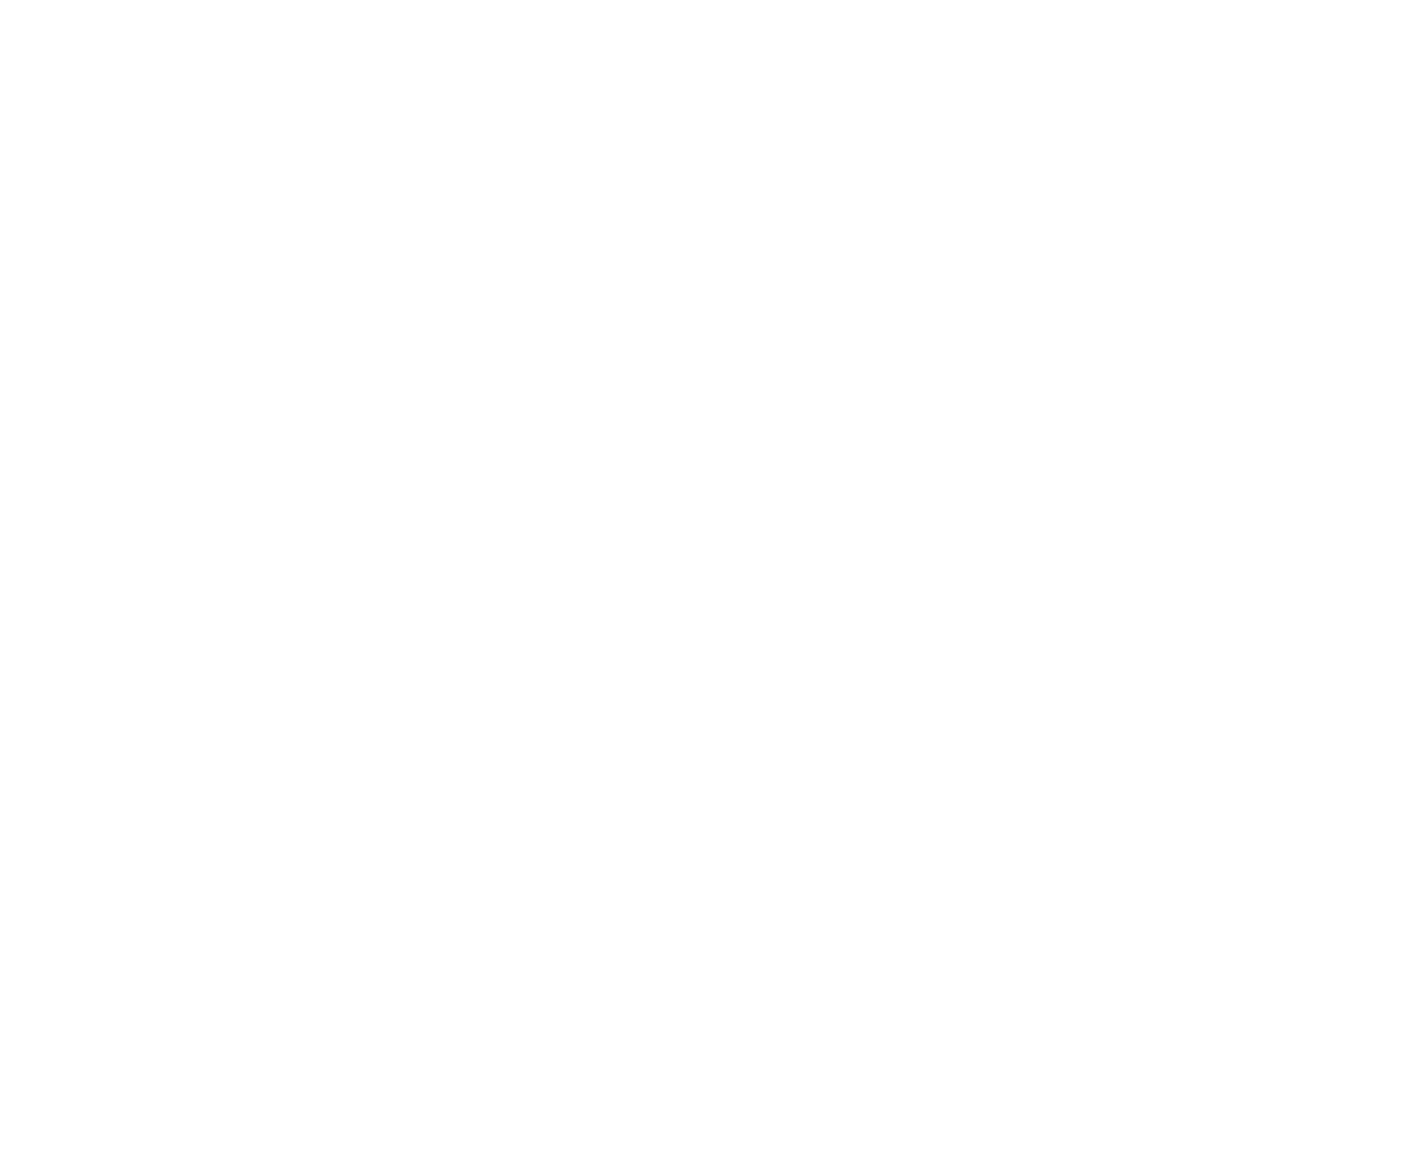

<IPython.core.display.Javascript object>


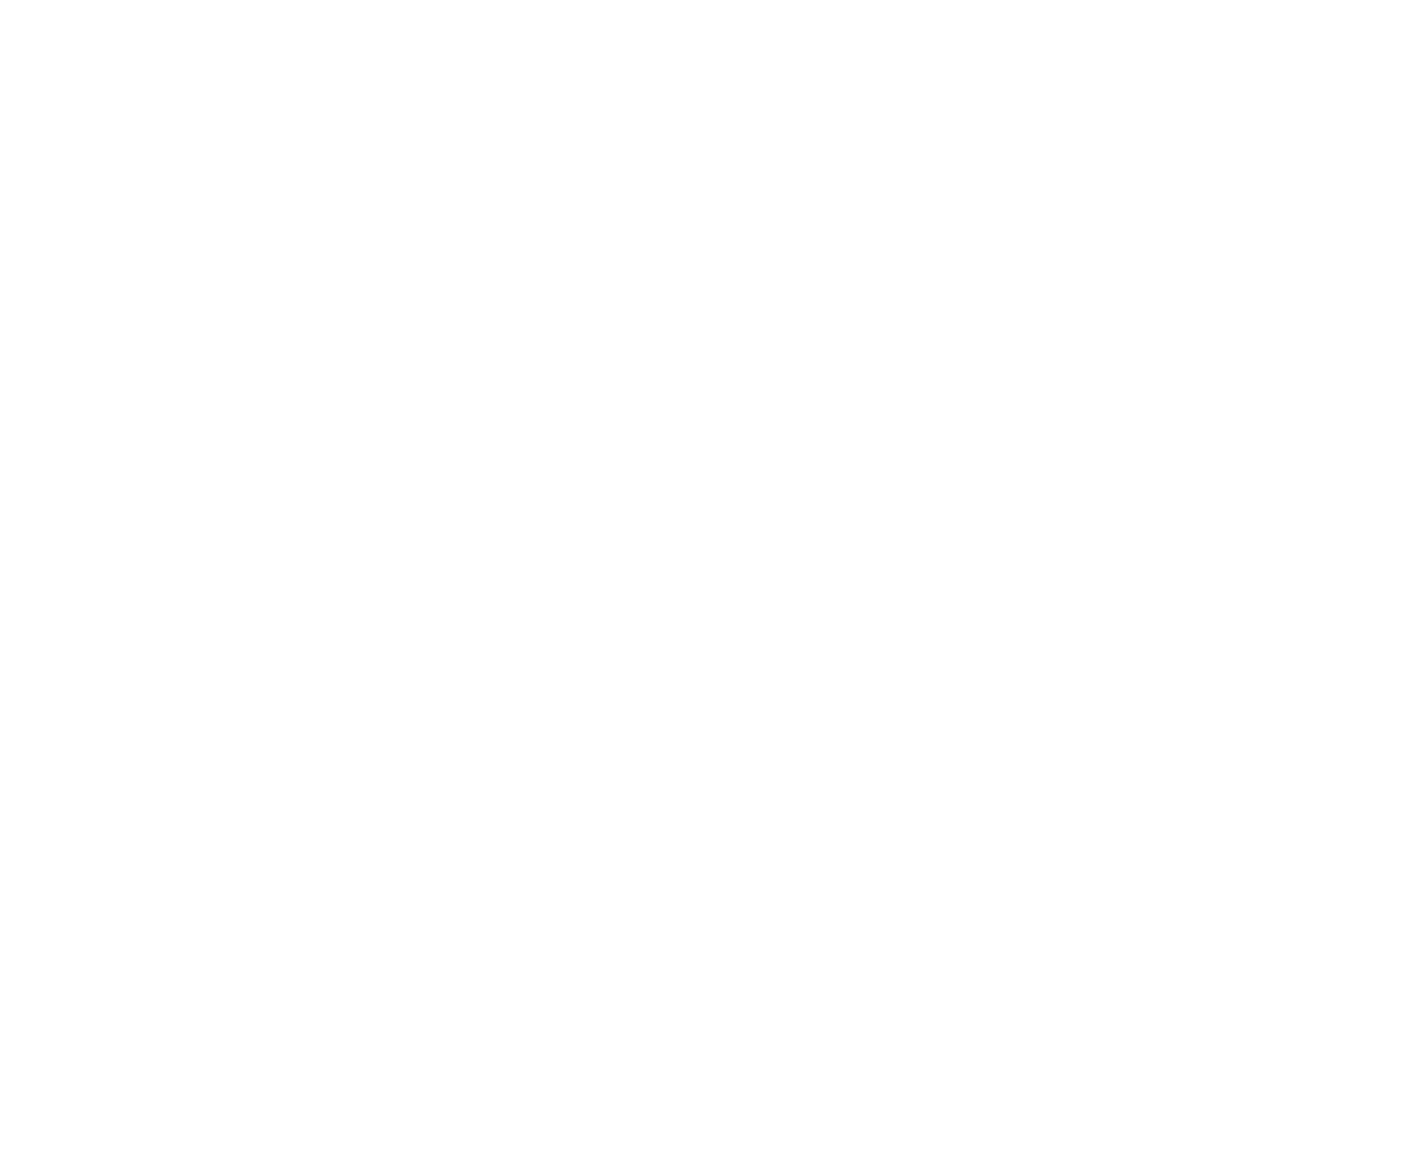

In [247]:
#Display Correlation Features: 
import seaborn as sns

d = simple_multi_dataset
#d = simple_misc_multiclass_df


#Need to bin the data for the correlation matrix: 
#IMU A1 = bin(IMU A1)
#etc.


# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#f,ax = plt.subplots(figsize=(18, 18))
#sns.heatmap(X, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [248]:
#Need to balance labels with SMOTE, ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)


#sm = SMOTE(sampling_strategy='all', random_state=12, ratio=1.0)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train)  #oversample on only the training data, after splitting the data initially into training and testing sets

#X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
#_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)


print(X_train_res.shape)
print(y_train_res.shape)

count_y_float = 0
count_y_paddle = 0
count_y_surf = 0

for y in y_train_res: 
    if y == "FLOATING":
        count_y_float+=1
    if y == "PADDLING":
        count_y_paddle+=1
    if y == "SURFING":
        count_y_surf+=1
        
print(count_y_float)
print(count_y_paddle)
print(count_y_surf)


print("Done")


(11694, 10)
(11694,)
3898
3898
3898
Done


## Multinomial Logistic Regression on Unfiltered IMU Signals

In [249]:
 # Train multinomial logistic regression model using SMOTE
from sklearn import linear_model
from sklearn import metrics

#Using SMOTE: 
print("Using SMOTE: \n")
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])
print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)
    

#Print score:
from sklearn.model_selection import cross_val_score
print(mul_lr.score(X_test, y_test))

#cm.poof()



Using SMOTE: 

Multinomial Logistic regression Train Accuracy ::  0.6080041046690611
Multinomial Logistic regression Test Accuracy ::  0.6218236173393124
When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[264  57  93]
 [ 55 136  39]
 [  8   1  16]]
0.6218236173393124


In [250]:
 # Train multinomial logistic regression model *without* using SMOTE

print("\nNot using SMOTE: \n")
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))

# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=["FLOATING", "PADDLING", "SURFING", "MISC"])

print("When printing the confusion matrix, the diaganols tell us the number of correct predictions.") 
print(cm)

#Print score:
from sklearn.model_selection import cross_val_score
print(mul_lr.score(X_test, y_test))



Not using SMOTE: 

Multinomial Logistic regression Train Accuracy ::  0.7672370825718557
Multinomial Logistic regression Test Accuracy ::  0.7428998505231689
When printing the confusion matrix, the diaganols tell us the number of correct predictions.
[[385  26   3]
 [125 105   0]
 [ 13   5   7]]
0.7428998505231689


In [251]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 12)
print(score)

[0.68965517 0.73684211 0.73214286 0.76785714 0.73214286 0.64285714
 0.70909091 0.85454545 0.74545455 0.78181818 0.69090909 0.72727273]


In [252]:
print("Average score from confusion matrix:")
print(sum(score)/len(score))

Average score from confusion matrix:
0.7342156822306549
